# **PREDICTING STROKE RISK: A MULTI-ALGORITHM APPROACH USING MACHINE LEARNING**

#0. Importing the Necessary Libraries

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from collections import defaultdict
from scipy.stats import norm
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


#1. Importing and Exploring Dataset

In [23]:

# Loading the stroke prediction dataset
df = pd.read_csv('/kaggle/input/dataset1/dataset.csv')
df.sample(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4262,47356,Female,42.0,0,0,Yes,Private,Urban,87.40,24.5,formerly smoked,0
19714,58542,Male,49.0,1,1,Yes,Govt_job,Rural,56.23,33.9,never smoked,0
15549,27052,Male,13.0,0,0,No,children,Rural,87.73,17.6,NaN,0
15798,55649,Female,45.0,0,0,Yes,Self-employed,Urban,84.11,30.0,NaN,0
10873,43212,Female,14.0,0,0,No,children,Urban,61.15,22.2,never smoked,0
22707,52693,Male,23.0,0,0,Yes,Private,Rural,148.71,32.4,never smoked,0
12567,53288,Male,30.0,0,0,Yes,Private,Rural,105.95,38.4,formerly smoked,0
22197,20558,Female,52.0,0,0,Yes,Private,Rural,217.73,42.9,smokes,1
7277,44302,Female,70.0,0,0,Yes,Govt_job,Rural,62.90,25.0,never smoked,0
20098,23894,Male,49.0,0,0,Yes,Private,Rural,102.38,38.4,formerly smoked,0


### Dropping column 'id' as it can cause unwanted correlation.


In [24]:
df.drop("id", axis=1, inplace=True)

In [25]:
df.sample(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
18892,Female,17.0,0,0,No,Private,Rural,100.11,42.7,NaN,0
13349,Female,48.0,0,0,Yes,Govt_job,Rural,101.94,32.8,formerly smoked,0
36332,Male,62.0,0,0,Yes,Self-employed,Urban,140.33,30.3,formerly smoked,0
28659,Female,38.0,0,0,Yes,Self-employed,Rural,67.38,24.7,NaN,0
34947,Male,4.0,0,0,No,children,Urban,80.42,16.9,NaN,0


### Variable Description



*   id: unique identifier

*   gender: "Male", "Female" or "Other"


*   age: age of the patient
*   heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

*  hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
*   ever_married: "No" or "Yes"

*   work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
*   Residence_type: "Rural" or "Urban"

*   avg_glucose_level: average glucose level in blood

*   bmi: body mass index
*   smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*


*   stroke: 1 if the patient had a stroke or 0 if not




In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


### Univariate Variable Analysis



*   **Categorical Variables**: 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
*   **Numerical Variables**: 'id', 'hypertension', 'heart_disease', 'stroke'



### Categorical Variables

In [27]:
def bar_plot(variable):
    # get feature
    var = df[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()

    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}:\n{}".format(variable,varValue))

In [28]:
categorical = (df.dtypes == "object")
categorical_list = list(categorical[categorical].index)

print("Categorical variables:")
print(categorical_list)

Categorical variables:
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


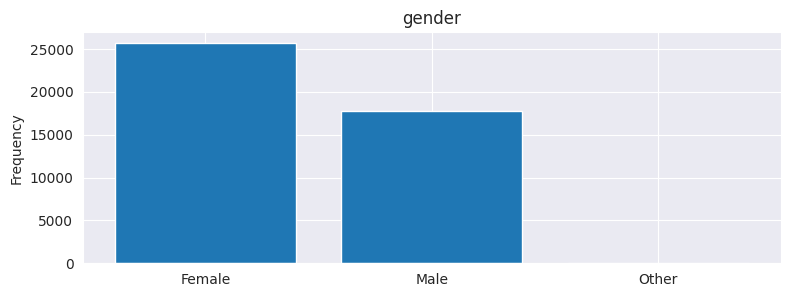

gender:
gender
Female    25665
Male      17724
Other        11
Name: count, dtype: int64


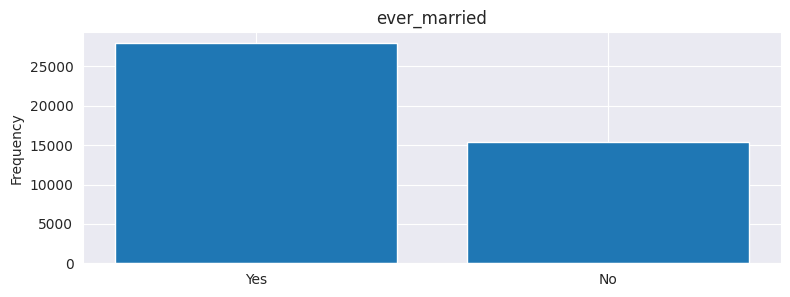

ever_married:
ever_married
Yes    27938
No     15462
Name: count, dtype: int64


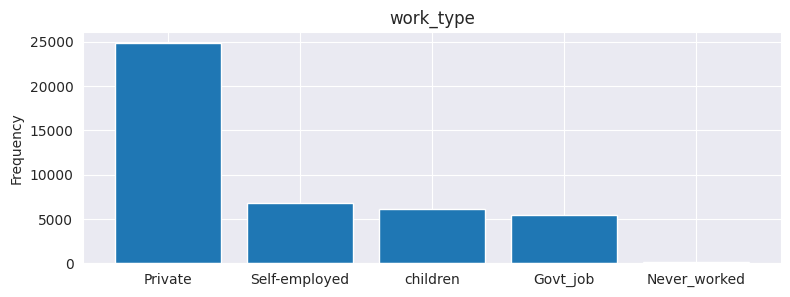

work_type:
work_type
Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: count, dtype: int64


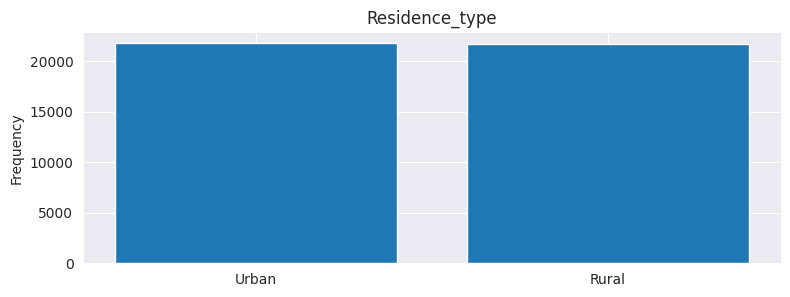

Residence_type:
Residence_type
Urban    21756
Rural    21644
Name: count, dtype: int64


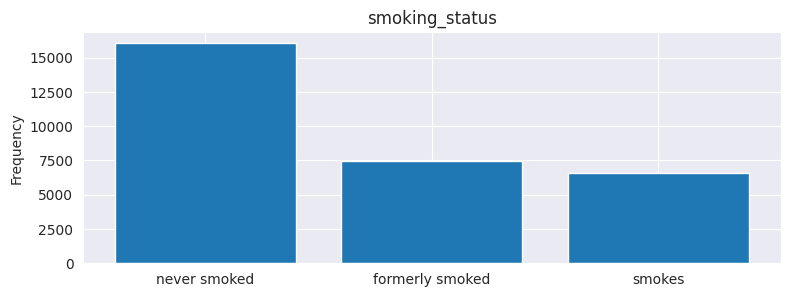

smoking_status:
smoking_status
never smoked       16053
formerly smoked     7493
smokes              6562
Name: count, dtype: int64


In [29]:
sns.set_style('darkgrid')
categorical_variables = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for c in categorical_variables:
    bar_plot(c)

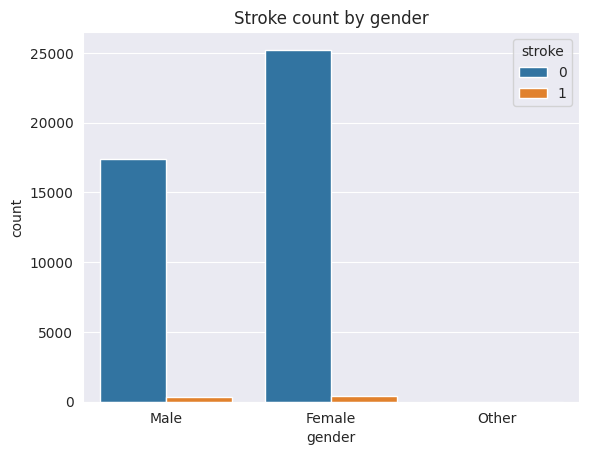

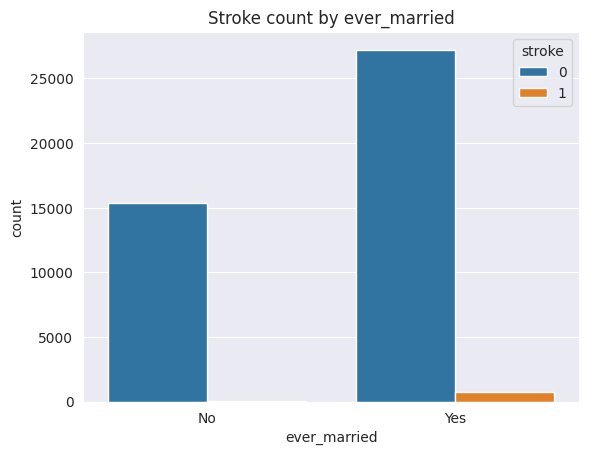

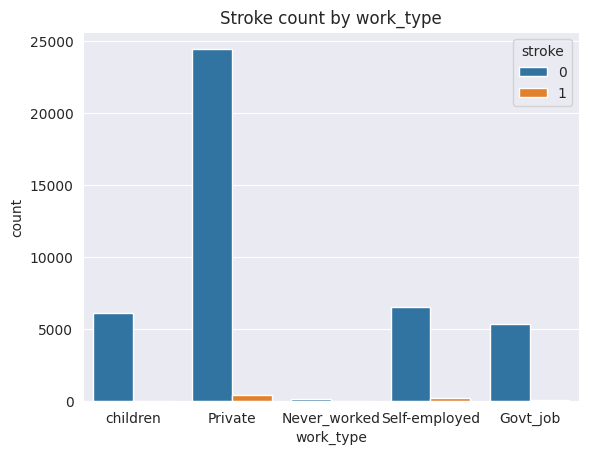

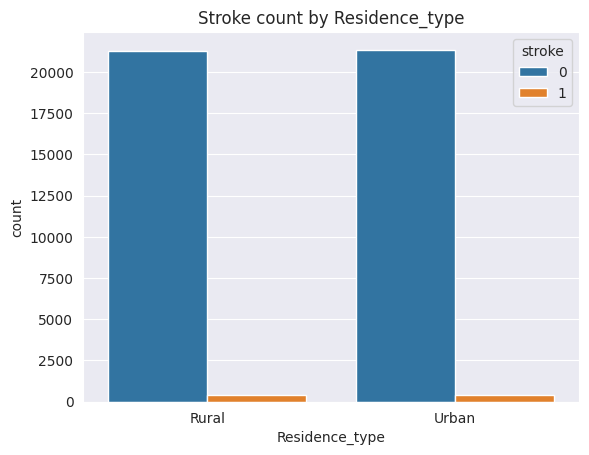

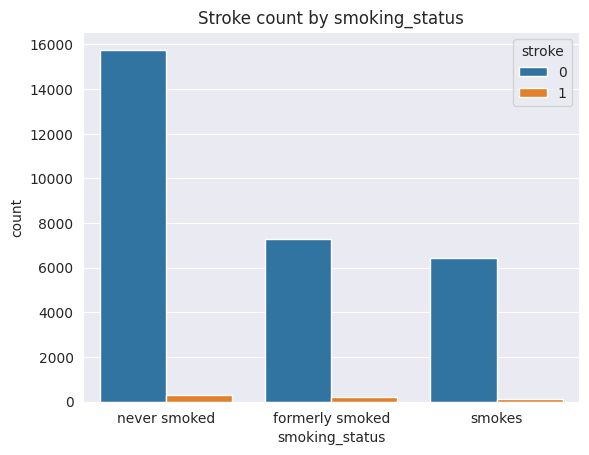

In [30]:
# Plot graphs that show the number who had stroke for categorical features.
for feature in categorical_list:
    title = "Stroke count by " + feature
    sns.countplot(data=df, x=feature, hue="stroke")
    plt.title(title)
    plt.show()

### Numerical Variables

In [31]:
numerical_int64 = (df.dtypes == "int64")
numerical_int64_list = list(numerical_int64[numerical_int64].index)

print("Numerical variables:")
print(numerical_int64_list)

Numerical variables:
['hypertension', 'heart_disease', 'stroke']


In [32]:
#plots for numerical features vs frequency

def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(df[variable], bins = 2)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} Distribution with Histogram".format(variable))
    plt.show()

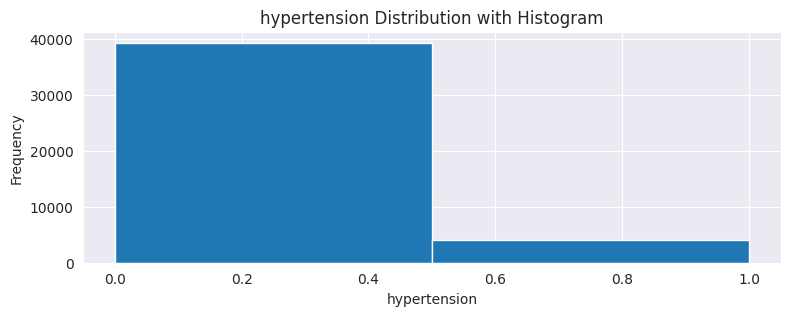

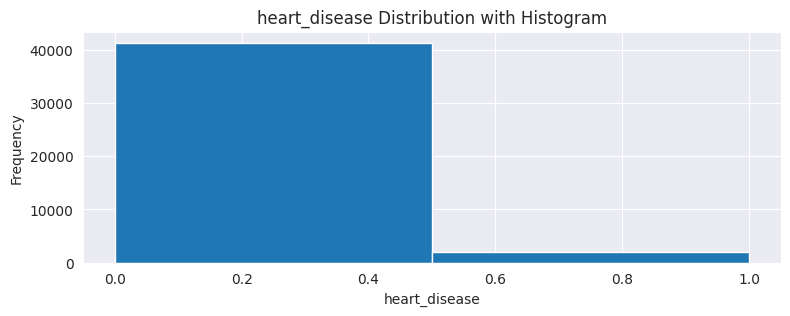

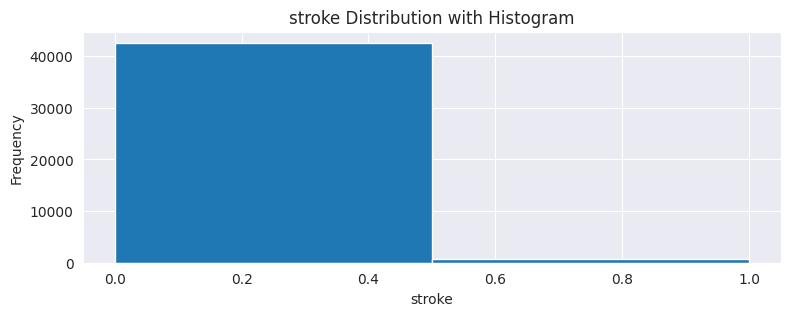

In [33]:
for n in numerical_int64_list:
    plot_hist(n)

In [34]:
numerical_float64 = (df.dtypes == "float64")
numerical_float64_list = list(numerical_float64[numerical_float64].index)

print("Numerical variables:")
print(numerical_float64_list)

Numerical variables:
['age', 'avg_glucose_level', 'bmi']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'avg_glucose_level Interval and Counts')

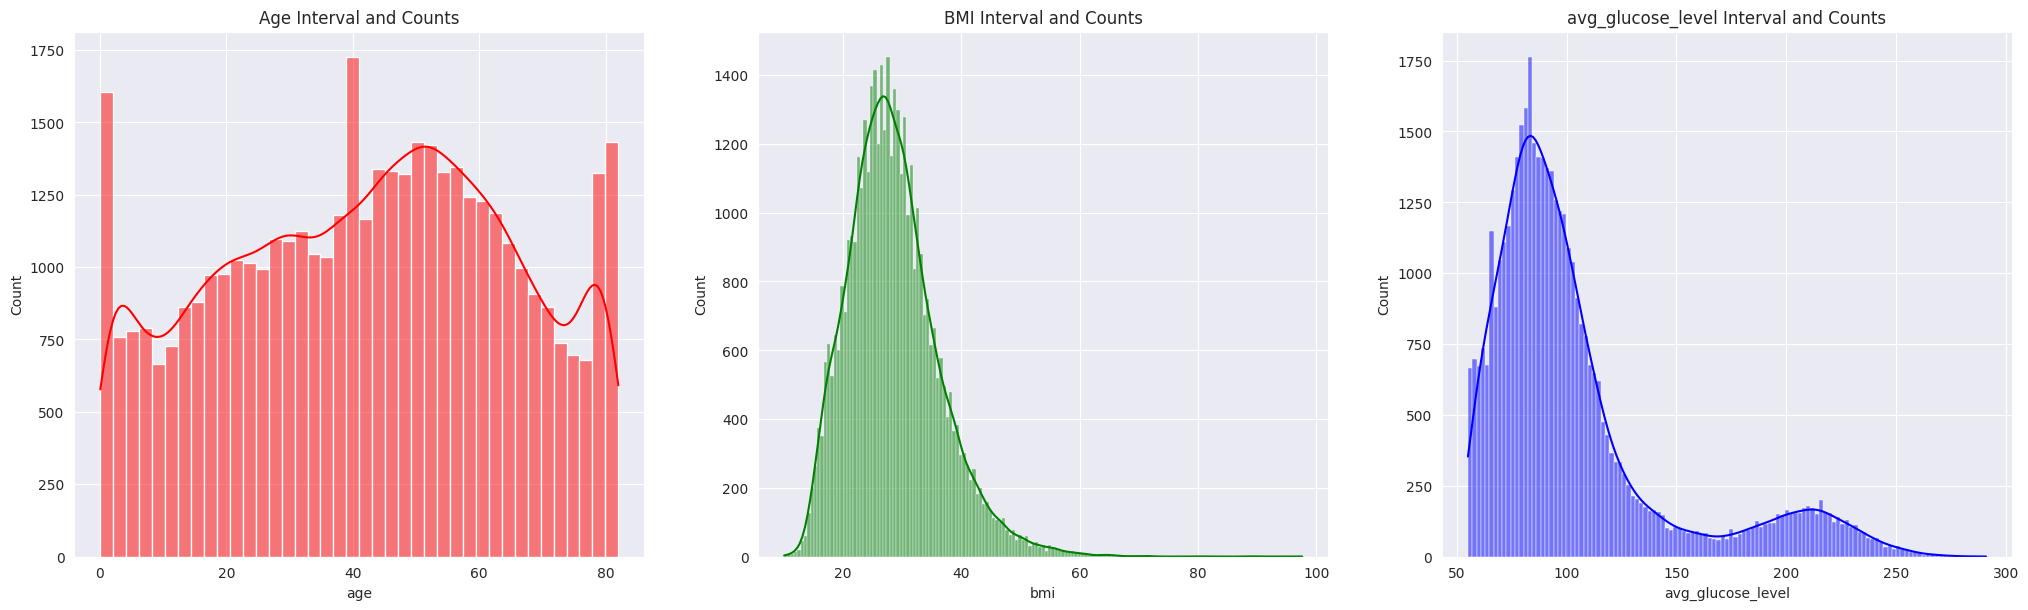

In [35]:
plt.figure(figsize=(25,15))

plt.subplot(2,3,1)
sns.histplot(df['age'], color = 'red', kde = True).set_title('Age Interval and Counts')

plt.subplot(2,3,2)
sns.histplot(df['bmi'], color = 'green', kde = True).set_title('BMI Interval and Counts')

plt.subplot(2,3,3)
sns.histplot(df['avg_glucose_level'], kde = True, color = 'blue').set_title('avg_glucose_level Interval and Counts')

In [36]:

# sns.set_theme(style="darkgrid")

# plt.figure(figsize=(20,15))

# plt.subplot(2,2,1)
# sns.swarmplot(x="stroke", y="age",hue="gender", data=df, palette="PRGn")

# plt.subplot(2,2,2)
# sns.swarmplot(x="stroke", y="age",hue="ever_married", data=df, palette="PRGn")

# plt.subplot(2,2,3)
# sns.swarmplot(x="stroke", y="age",hue="smoking_status", data=df, palette="PRGn")

# plt.subplot(2,2,4)
# sns.swarmplot(x="stroke", y="age",hue="work_type", data=df, palette="PRGn")

# plt.show()

# 5. Correlation

In [75]:
pd=df
pd=pd.dropna()
pd.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [76]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for feature in categorical_list:
    pd.loc[:, feature] = label_encoder.fit_transform(pd[feature])

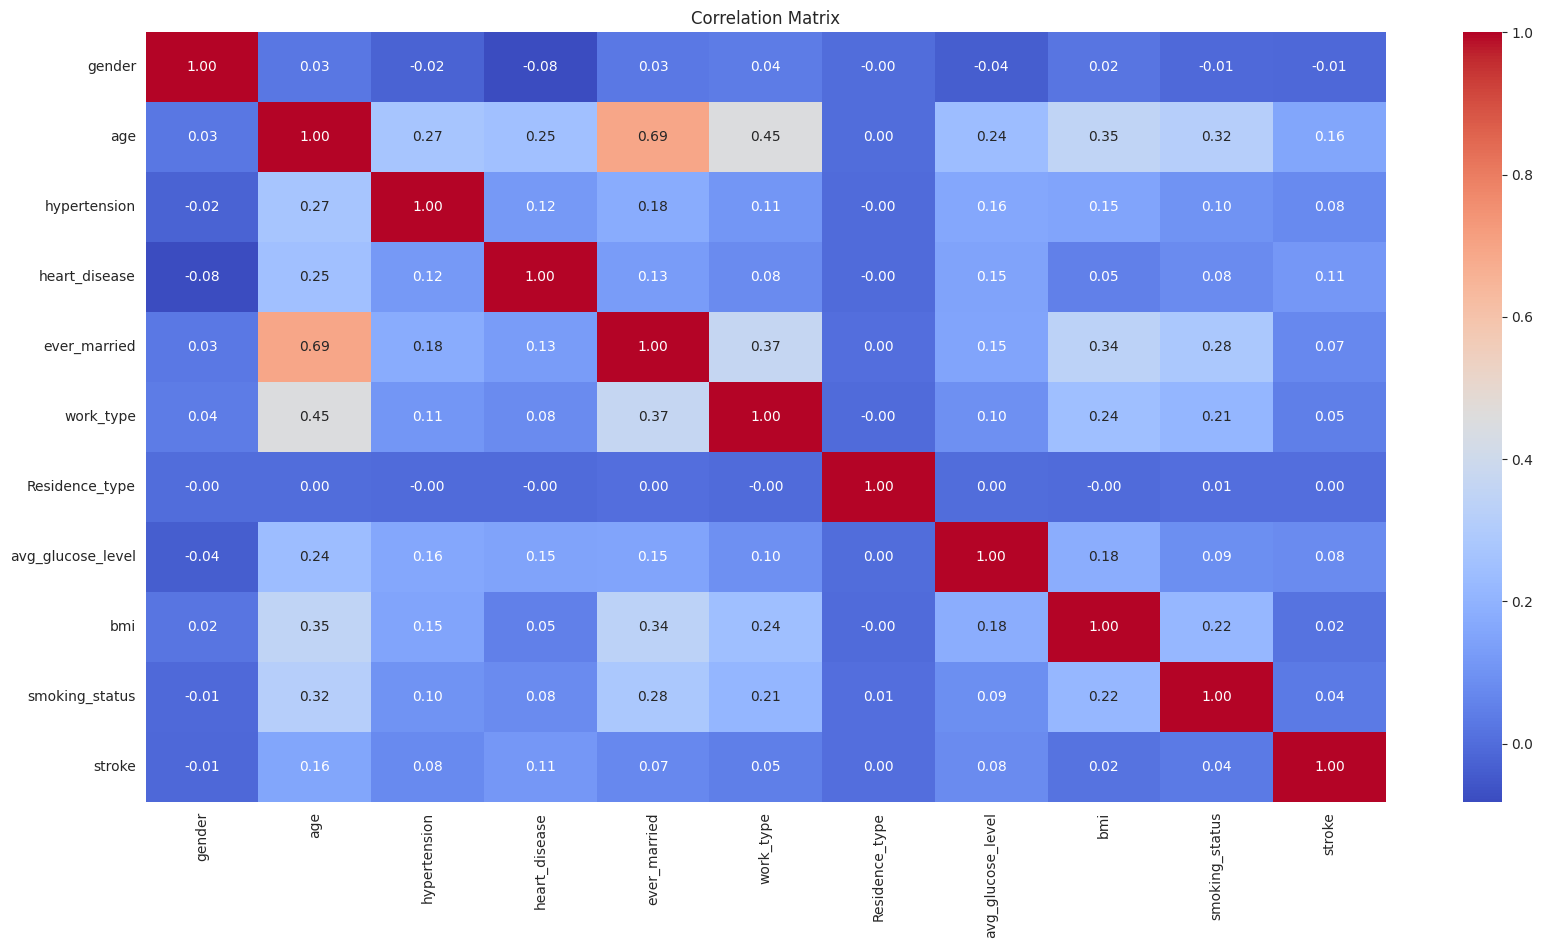

In [77]:
correlation_matrix = pd.corr()

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

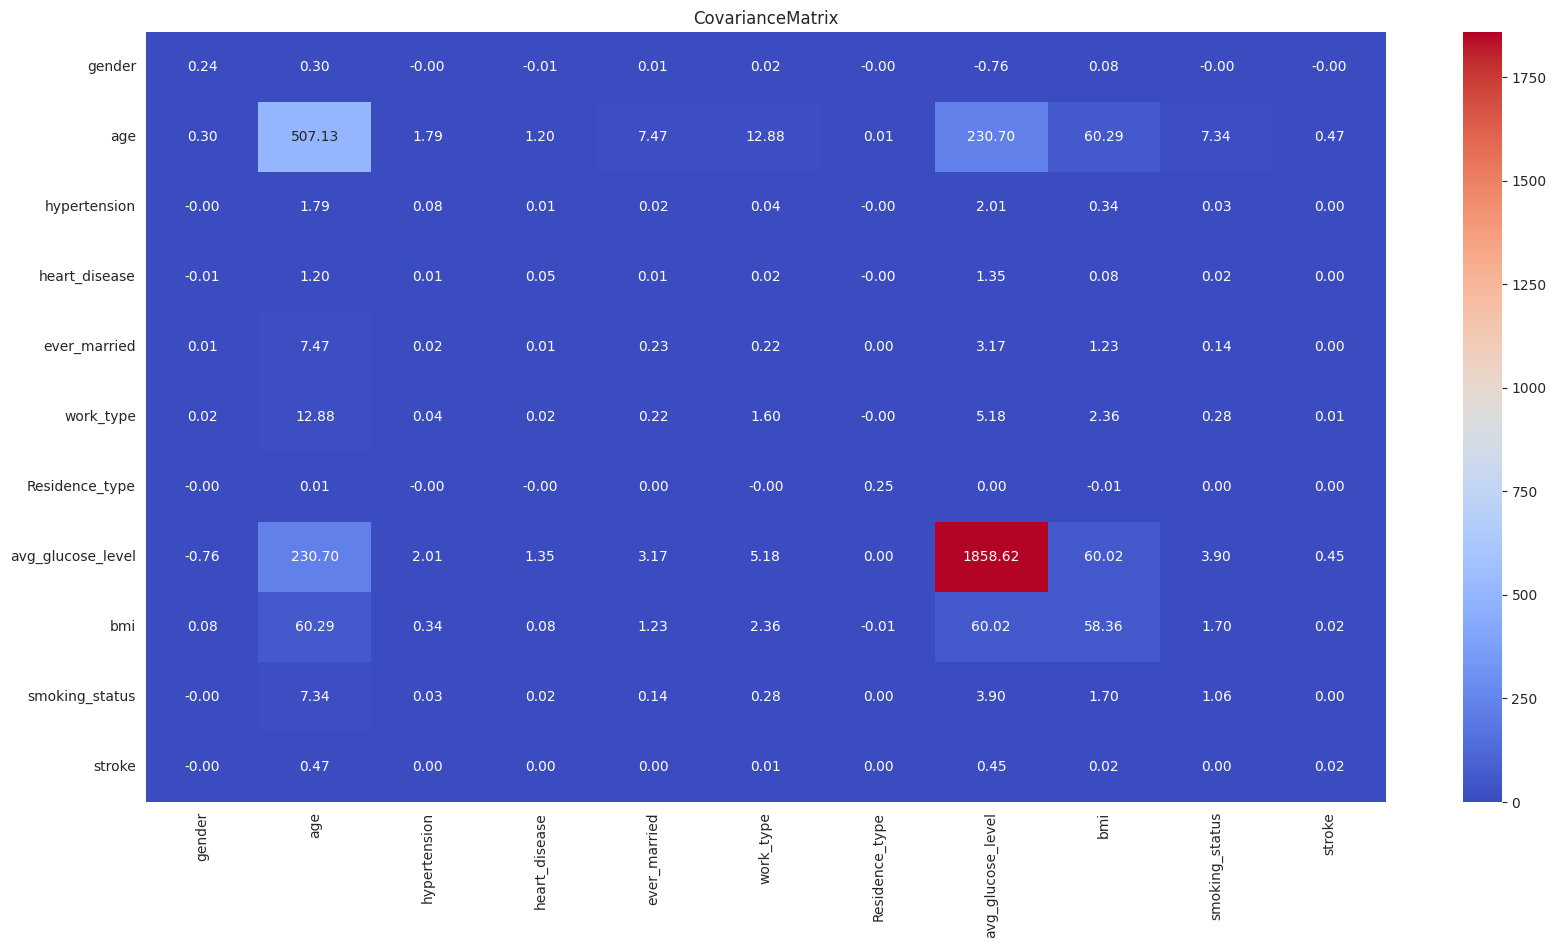

In [78]:
Covariance_matrix = pd.cov()

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(Covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('CovarianceMatrix')
plt.show()

## **6. Handling the Null Value**

#### Checking that if there exist any dependencies in the dataset so that we can generate the missing values using ml model

* Since the covariance and correlation factor of bmi ans Somking_status is very less,so ve cannot use any preditive models for estmating the missing values.
* Since the nof rows which contains the na values is significant so we can't simply drop the columns with the null entries.
* So we use normal imputation for handling the null values.
* we will use median for the bmi missed values and  unknown as the missed values for smoking_status.

#### Due to high no.of outliers in the boxplot of 'bmi', instead of mean, median would be a better choice to replace the null values.

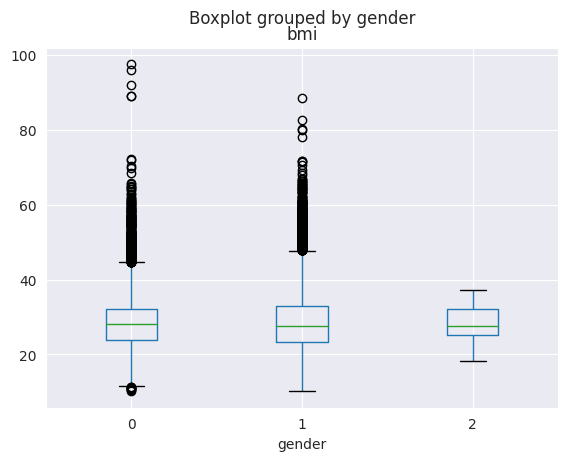

In [79]:
df.boxplot(column="bmi",by = "gender")
plt.show()

In [80]:
print("Mean of BMI value for Females: ", df[df['gender'] == 'Female']['bmi'].median())
print("Mean of BMI value for Males: ", df[df['gender'] == 'Male']['bmi'].median())
print("Mean of BMI value for Others: ", df['bmi'].median())

Mean of BMI value for Females:  nan
Mean of BMI value for Males:  nan
Mean of BMI value for Others:  27.7


In [81]:
df['bmi'] =df['bmi'].fillna(0)

In [82]:
for i in range(43400):
    if df['bmi'][i] == 0:
        if df['gender'][i] == 'Male':
            df.loc[i, 'bmi'] = 28.1
        elif df['gender'][i] == 'Female':
            df.loc[i, 'bmi'] = 27.5
        else:
            df.loc[i, 'bmi'] = 27.7


In [83]:
#testing null values in any attributes now
df[df['bmi'].isnull()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [84]:
#the values of the na entries of the smoking_status is filled by 'unknown'
df['smoking_status'] = df['smoking_status'].fillna('unknown')

In [85]:
#check if na values of bmi and smoking_status are now 0
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## 7. Encoding

In [86]:
#The values of the discrete features are replaced by some encoding like 0,1,2 since for the sake of simplicity
def label_encoder(column):
    labels = column.unique()
    label_mapping = {label: i for i, label in enumerate(labels)}
    encoded_column = column.map(label_mapping)
    return encoded_column, label_mapping

In [87]:
categorical_features = df[["gender", "hypertension", "heart_disease", "ever_married", 
                       "work_type", "Residence_type", "smoking_status","stroke"]]
for feature in categorical_features:
    encoded_column, label_mapping = label_encoder(df[feature])  # Use the variable directly
    df[feature] = encoded_column  # Assign the encoded column back to the DataFrame

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  int64  
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  int64  
 5   work_type          43400 non-null  int64  
 6   Residence_type     43400 non-null  int64  
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                43400 non-null  float64
 9   smoking_status     43400 non-null  int64  
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 3.6 MB


## 8. Train - Test Split

In [89]:
#dividing the data set into the labels and observations
X=df.drop(['stroke'],axis=1)
Y=df['stroke']

In [90]:
#dividing the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,shuffle=True,random_state=42)

In [91]:
Y_train.value_counts()

stroke
0    31975
1      575
Name: count, dtype: int64

In [92]:
Y_test.value_counts()

stroke
0    10642
1      208
Name: count, dtype: int64

#### Since the dataset is more biased to the case stroke does not occur so we have sample the data to the model accuracy

## 9. Over-Sampling of Imbalanced Data

#### The dataset used for the training is biased so we use some techniques such as
* Random oversampling
* SMOTE

**undersampling is not used because it may lead to loss of the data.**

### Implementation of SMOTE from scratch

In [93]:


def SMOTE_imp(X, y, k, ratio='auto'):
    """
    Generate synthetic samples using SMOTE technique.

    Parameters:
        X (array-like): Features of the dataset.
        y (array-like): Labels of the dataset.
        k (int): Number of nearest neighbors to consider.
        ratio (str or float): Ratio of synthetic samples to be generated compared to the original samples.
            - If 'auto', the ratio will be determined automatically to achieve a 1:1 ratio for minority and majority classes.
            - If a float, it represents the desired ratio of minority class samples to majority class samples.

    Returns:
        X_resampled (array-like): Resampled features.
        y_resampled (array-like): Resampled labels.
    """
    # Calculate class distribution
    class_counts = np.bincount(y)
    minority_class = np.argmin(class_counts)
    majority_class = np.argmax(class_counts)

    if ratio == 'auto':
        # Calculate ratio to achieve 1:1 balance
        ratio = class_counts[majority_class] / class_counts[minority_class]
    elif isinstance(ratio, float):
        pass  # Ratio is provided by the user
    else:
        raise ValueError("Invalid value for 'ratio'. It should be 'auto' or a float.")

    # Initialize variables
    X_resampled = []
    y_resampled = []
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(X)

    # Calculate SMOTE
    for i in range(len(X)):
        # Find k-nearest neighbors
        if(y[i]==1):
            neighbors = nn.kneighbors([X[i]], return_distance=False)[:, 1:]
            # Generate synthetic samples
            for j in range(int(ratio)):
                # Randomly select one of the k-nearest neighbors
                nn_index = np.random.choice(neighbors[0])
                diff = X[nn_index] - X[i]
                # Generate synthetic sample

                synthetic_sample = X[i] + np.random.rand() * diff
                X_resampled.append(synthetic_sample)
                y_resampled.append(y[i])
        if(y[i]==0):
            X_resampled.append(X[i])
            y_resampled.append(y[i])

    return np.array(X_resampled), np.array(y_resampled)

In [94]:
# Example usage
X_minority = X_train.to_numpy()
y_minority = Y_train.to_numpy()

X_resampledSMOTE_Train, y_resampledSMOTE_Train = SMOTE_imp(X_minority, y_minority, k=5, ratio='auto')

In [95]:
y_resampledSMOTE_Train.shape

(63600,)

In [96]:
y_resampledSMOTE_Train.sum()

31625

### Impementation of Random Over Sampling from scratch

In [97]:
import pandas as pd
import numpy as np

def random_oversample(X, y, minority_class_label):
    """
    Randomly oversample the minority class to balance the dataset.

    Parameters:
    X (numpy array or pandas DataFrame): Feature matrix
    y (numpy array or pandas Series): Target labels
    minority_class_label: Label of the minority class

    Returns:
    X_resampled (numpy array): Resampled feature matrix
    y_resampled (numpy array): Resampled target labels
    """
    # Convert input to numpy arrays if they are pandas DataFrames/Series
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    # Separate majority and minority classes
    majority_indices = np.where(y != minority_class_label)[0]
    minority_indices = np.where(y == minority_class_label)[0]
    
    # Count the number of samples in the minority class
    minority_samples_count = len(minority_indices)
    
    # Randomly sample indices from the minority class with replacement
    sampled_minority_indices = np.random.choice(minority_indices, size=majority_indices.shape[0], replace=True)
    
    # Combine minority samples with majority samples
    resampled_indices = np.concatenate((majority_indices, sampled_minority_indices))
    
    # Shuffle the combined indices
    np.random.shuffle(resampled_indices)
    
    # Create resampled feature matrix and target labels
    X_resampled = X[resampled_indices]
    y_resampled = y[resampled_indices]
    
    return X_resampled, y_resampled

In [98]:
# Apply random oversampling to the training set
X_resampledROS_Train, y_resampledROS_Train = random_oversample(X_train, Y_train, minority_class_label=1)

In [99]:
y_resampledROS_Train.shape

(63950,)

In [100]:
y_resampledROS_Train.sum()

31975

In [101]:
#Ramdom oversampling technique

ros = RandomOverSampler(random_state=42)
X_randTrain, Y_randTrain = ros.fit_resample(X_train, Y_train)


In [102]:
Y_randTrain.value_counts()

stroke
0    31975
1    31975
Name: count, dtype: int64

In [103]:
#SMOTE

smote = SMOTE(random_state=43)
X_smoteTrain, Y_smoteTrain = smote.fit_resample(X_train, Y_train)

In [104]:
Y_smoteTrain.value_counts()

stroke
0    31975
1    31975
Name: count, dtype: int64

## 10. Logistic Regression
#### We will implement decision tree from scratch and evaluate performance

In [152]:
class LogisticRegressionFromScratch:
    def __init__(self, learning_rate=1, num_iterations=140, threshold=0.5):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.threshold = threshold
        self.weights = None
        self.bias = None
        self.mean = None
        self.std = None
        self.losses = []  # List to store loss values during training

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _standardize(self, X, fit=False):
        if fit:
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0)
        X_standardized = (X - self.mean) / self.std
        return X_standardized

    def _initialize_parameters(self, num_features):
        self.weights = np.zeros(num_features)
        self.bias = 0

    def fit(self, X, y):
        X = self._standardize(X, fit=True)
        num_samples, num_features = X.shape
        self._initialize_parameters(num_features)
        W1 = y.shape[0] / (2 * y.sum())
        W0 = y.shape[0] / (2 * (y.shape[0] - y.sum()))

        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(linear_model)

            # Calculate loss
            loss = (-1 / num_samples) * np.sum(
                W1 * y * np.log(predictions) + W0 * (1 - y) * np.log(1 - predictions)
            )

            # Append loss to list for plotting
            self.losses.append(loss)

            # Gradient descent
            dw = (1 / num_samples) * np.dot(X.T, -(W1 * y * (1 - predictions)) + W0 * (1 - y) * predictions)
            db = (1 / num_samples) * np.sum(-(W1 * y * (1 - predictions)) + W0 * (1 - y) * predictions)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

        # Plot loss curve
#         plt.plot(range(1, self.num_iterations + 1), self.losses)
#         plt.xlabel('Iterations')
#         plt.ylabel('Loss')
#         plt.title('Loss Curve')
#         plt.show()

#         # Print final loss value
#         print('Final Loss:', self.losses[-1])

    def predict(self, X):
        X = self._standardize(X)
        linear_model = np.dot(X, self.weights) + self.bias
        predictions = self._sigmoid(linear_model)
        return np.where(predictions >= self.threshold, 1, 0)

    def predict_proba(self, X):
        X = self._standardize(X)
        linear_model = np.dot(X, self.weights) + self.bias
        probabilities = self._sigmoid(linear_model)
        return probabilities
    
    def evaluate(self, X, y):
        X = self._standardize(X)
        y_pred = self.predict(X)
        # Calculate accuracy
        accuracy = accuracy_score(y, y_pred)
        print("Accuracy:", accuracy)

        # Calculate precision
        precision = precision_score(y, y_pred)
        print("Precision:", precision)

        # Calculate recall
        recall = recall_score(y, y_pred)
        print("Recall:", recall)

        # Calculate F1 score
        f1 = f1_score(y, y_pred)
        print("F1 Score:", f1)

        # Generate confusion matrix
        conf_matrix = confusion_matrix(y, y_pred)

        # Plot confusion matrix using seaborn
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()


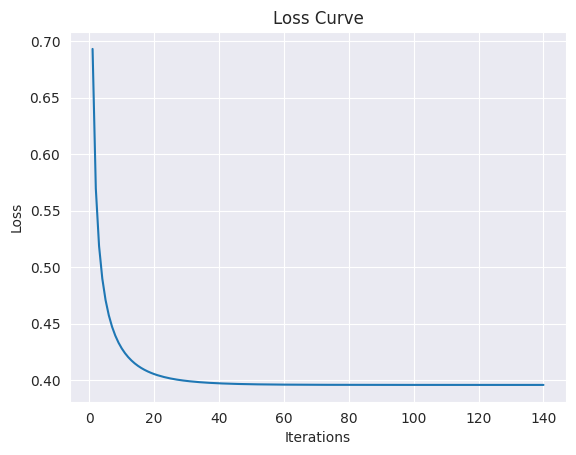

Final Loss: 0.39566080253794567
Accuracy: 0.6692165898617511
Precision: 0.008432683919744112
Recall: 0.13942307692307693
F1 Score: 0.015903482314230874


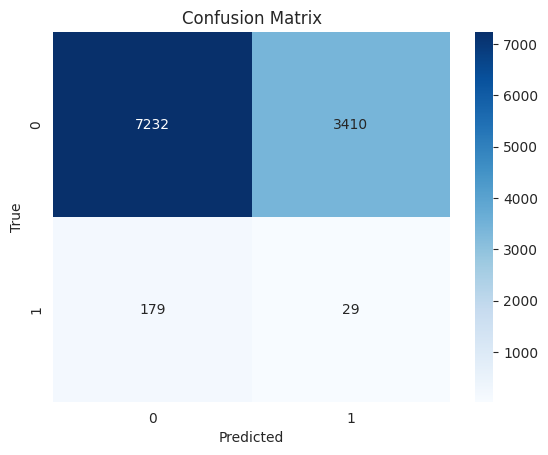

In [106]:
# checking for default smote
model1 = LogisticRegressionFromScratch(threshold = 0.05)
model1.fit(X_smoteTrain,Y_smoteTrain)
model1.evaluate(X_test,Y_test)

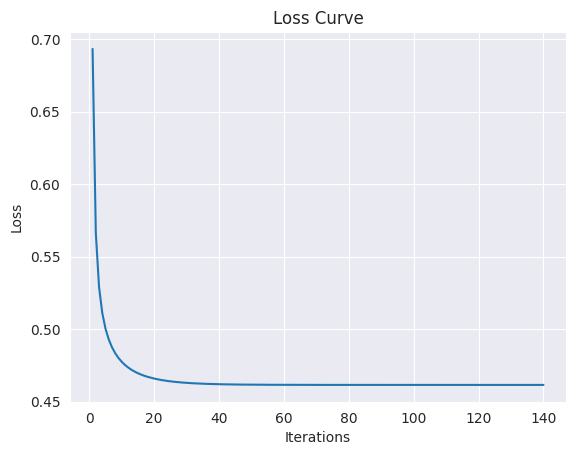

Final Loss: 0.4615309456561275
Accuracy: 0.7620276497695853
Precision: 0.04311008468052348
Recall: 0.5384615384615384
F1 Score: 0.07982893799002139


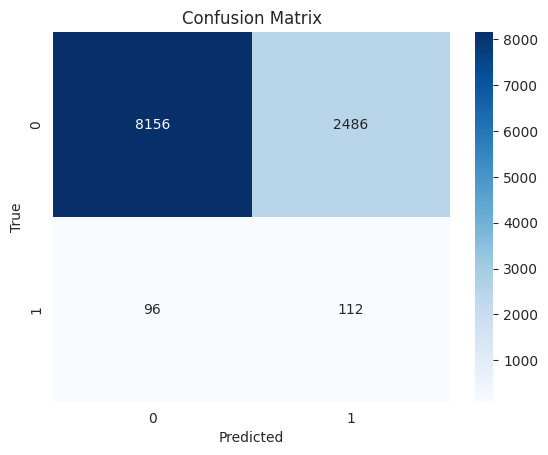

In [107]:
# checking for default randomoversampling
model2 = LogisticRegressionFromScratch(threshold = 0.0061)
model2.fit(X_randTrain, Y_randTrain)
model2.evaluate(X_test, Y_test)

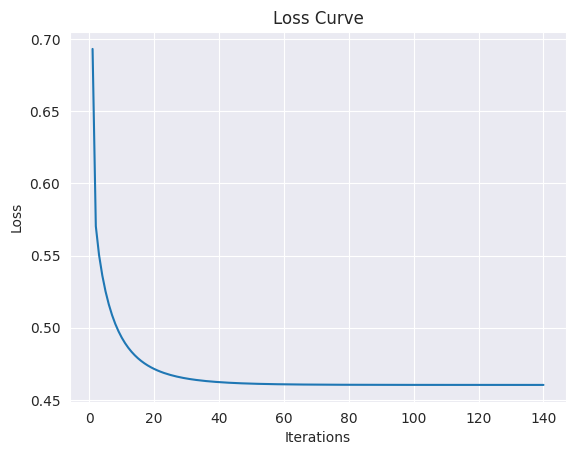

Final Loss: 0.46032321113838764
Accuracy: 0.7499539170506913
Precision: 0.04371584699453552
Recall: 0.5769230769230769
F1 Score: 0.08127328140873687


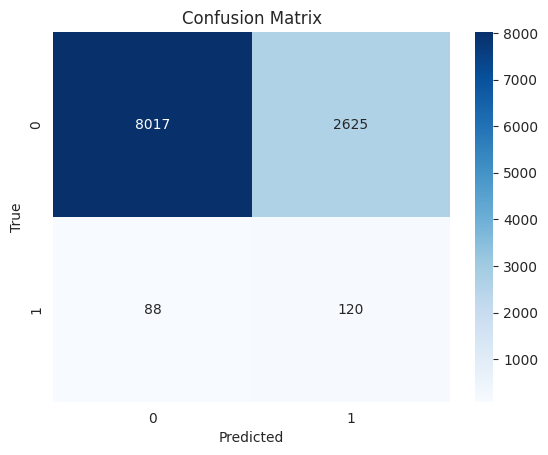

In [108]:
# checking for default train data
model2 = LogisticRegressionFromScratch(threshold = 0.0076, num_iterations = 140)
model2.fit(X_train, Y_train)
model2.evaluate(X_test, Y_test)

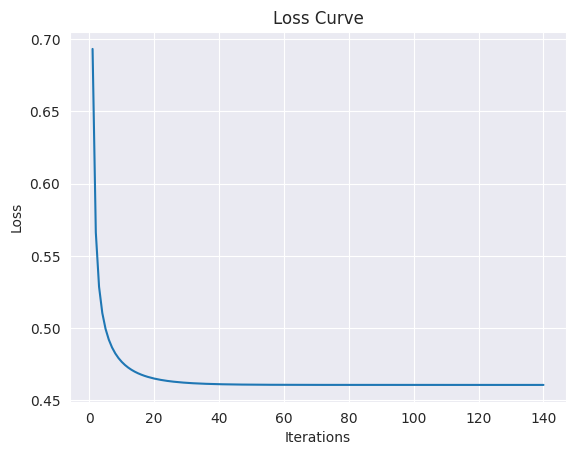

Final Loss: 0.46073442731019515
Accuracy: 0.7779723502304148
Precision: 0.04505994212484498
Recall: 0.5240384615384616
F1 Score: 0.08298439284354778


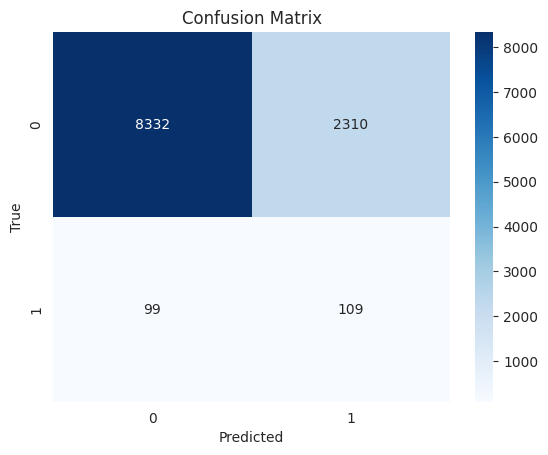

In [109]:
# checking for scratch implemented randomoversampling
model2 = LogisticRegressionFromScratch(threshold = 0.0061)
model2.fit(X_resampledROS_Train, y_resampledROS_Train)
model2.evaluate(X_test, Y_test)

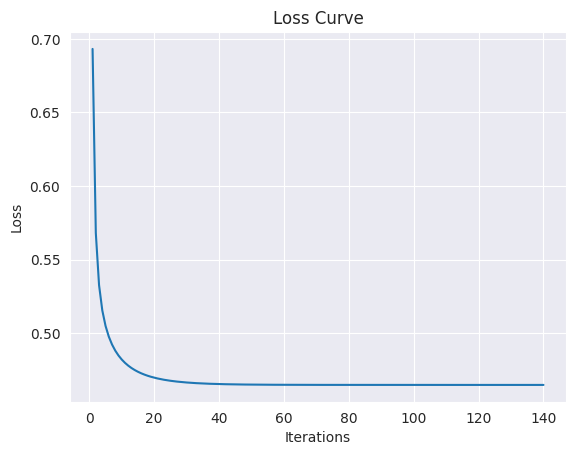

Final Loss: 0.4650018265945243
Accuracy: 0.7213824884792627
Precision: 0.04257393565160871
Recall: 0.6298076923076923
F1 Score: 0.07975646879756469


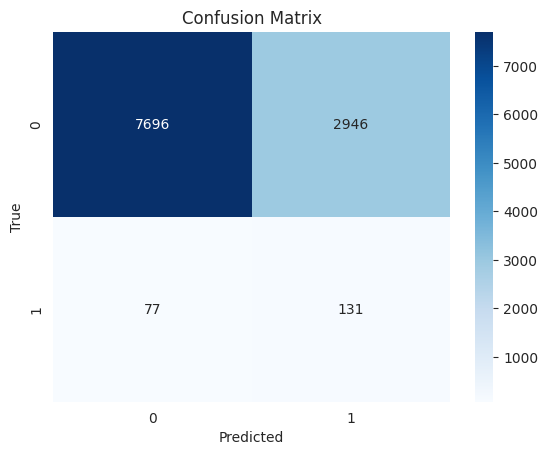

In [110]:
# checking for scratch implemented smote
model1 = LogisticRegressionFromScratch(threshold = 0.006)
model1.fit(X_resampledSMOTE_Train, y_resampledSMOTE_Train)
model1.evaluate(X_test,Y_test)

In [111]:
def logistic_regression_and_evaluation(X_train, X_test, y_train, y_test):
    if len(X_train) != len(y_train) or len(X_test) != len(y_test):
        raise ValueError("Number of samples in X and y do not match.")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the logistic regression model
    #model = LogisticRegression(class_weight={0: 1, 1: 150})
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Calculate precision
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)

    # Calculate recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix using seaborn
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.7942857142857143
Precision: 0.054969217238346524
Recall: 0.6009615384615384
F1 Score: 0.1007252215954875


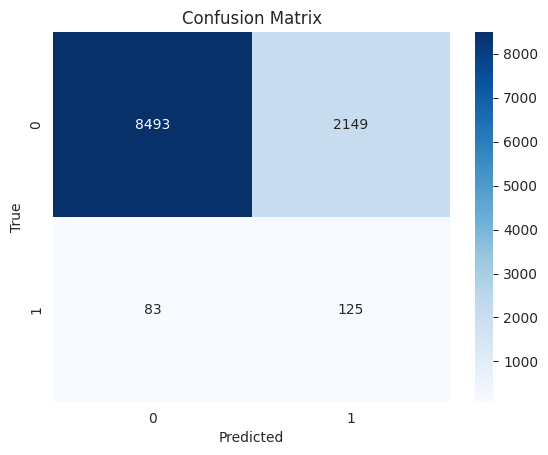

In [112]:
logistic_regression_and_evaluation(X_smoteTrain, X_test, Y_smoteTrain, Y_test)

Accuracy: 0.7355760368663594
Precision: 0.056056056056056056
Recall: 0.8076923076923077
F1 Score: 0.10483619344773791


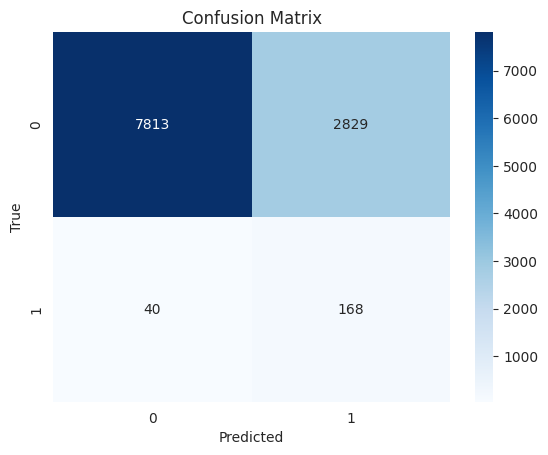

In [113]:
logistic_regression_and_evaluation(X_randTrain, X_test, Y_randTrain, Y_test)

Accuracy: 0.7359447004608295
Precision: 0.056130972268626796
Recall: 0.8076923076923077
F1 Score: 0.1049671977507029


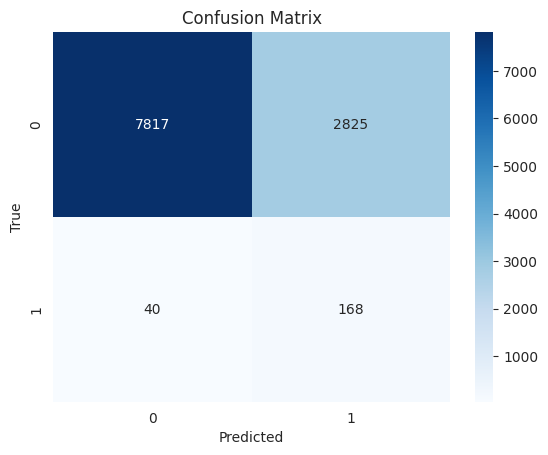

In [114]:
logistic_regression_and_evaluation(X_train, X_test, Y_train, Y_test)

## 11. Naive Bayes
#### We will implement decision tree from scratch and evaluate performance

In [218]:
import numpy as np
from collections import defaultdict
from scipy.stats import norm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore', message='.*use_inf_as_na.*')


class NaiveBayesClassifierFromScratch:
    def __init__(self):
        self.class_prior = {}
        self.mean = {}
        self.variance = {}
        self.scaler = StandardScaler()

    def fit(self, X, y, show_plots=False):
        X = self.scaler.fit_transform(X)

        n_samples, n_features = X.shape
        self.classes = np.unique(y)

        # Compute class prior probabilities
        class_counts = defaultdict(int)
        for label in y:
            class_counts[label] += 1
        for label in self.classes:
            self.class_prior[label] = class_counts[label] / n_samples

        # Compute mean and variance for each feature in each class
        for label in self.classes:
            label_indices = np.where(y == label)
            label_data = X[label_indices]
            self.mean[label] = np.mean(label_data, axis=0)
            self.variance[label] = np.var(label_data, axis=0)
            
        if show_plots:
            # Plotting normal distributions for each feature and each class
            n_features = X.shape[1]
            plt.figure(figsize=(20, 20 * n_features))

                    # Plotting normal distributions for each feature and each class
            n_features = X.shape[1]
            plt.figure(figsize=(20, 20))
            data = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']  
            for feature_idx in range(n_features):
                plt.subplot(5, 2, feature_idx + 1)
                for label in self.classes:
                    label_data = X[y == label][:, feature_idx]  # Selecting data for the current class label and feature
                    label_data = label_data[np.isfinite(label_data)]  # Filter out infinite values
                    sns.kdeplot(label_data, label=f'Class {label}', fill=True)
                plt.xlabel(data[feature_idx])
                plt.ylabel('Density')
                plt.title(f'Distributions for Feature {data[feature_idx]}')
                plt.legend()

            plt.tight_layout()
            plt.show()


    def predict(self, X):
        X = self.scaler.transform(X)

        predictions = []
        for sample in X:
            posteriors = []
            for label in self.classes:
                prior = self.class_prior[label]
                likelihood = np.sum(norm.logpdf(sample, self.mean[label], np.sqrt(self.variance[label])))
                posterior = prior + likelihood
                posteriors.append(posterior)
            predicted_label = self.classes[np.argmax(posteriors)]
            predictions.append(predicted_label)
        return predictions
    def predict_proba(self, X):
            X = self.scaler.transform(X)

            probabilities = []
            for sample in X:
                posteriors = []
                for label in self.classes:
                    prior = self.class_prior[label]
                    likelihood = np.sum(norm.logpdf(sample, self.mean[label], np.sqrt(self.variance[label])))
                    posterior = prior + likelihood
                    posteriors.append(posterior)
                posteriors = np.exp(posteriors - np.max(posteriors))  # Normalize using log-sum-exp trick
                probabilities.append(posteriors / np.sum(posteriors))  # Normalize to get probabilities
            return probabilities
        
    def evaluate(self, y_true, y_pred, label='y_pred'):
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            confusion = confusion_matrix(y_true, y_pred)
            print(f"{label} Metrics:")
            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1-score:", f1)
            print("Confusion Matrix:")

            # Plotting confusion matrix using Seaborn heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.title(f'Confusion Matrix for {label}')
            plt.show()

            return accuracy, precision, recall, f1

    def compare_performance(self, y_true, y_pred, y_smote, y_rand):
            # Evaluate metrics for each set of predictions
            metrics_y_pred = self.evaluate(y_true, y_pred, label='y_pred')
            metrics_y_smote = self.evaluate(y_true, y_smote, label='y_smote')
            metrics_y_rand = self.evaluate(y_true, y_rand, label='y_rand')

            # Plot comparison between metrics
            labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
            metrics_names = ['accuracy', 'precision', 'recall', 'f1']
            y_pred_metrics = [metrics_y_pred[0], metrics_y_pred[1], metrics_y_pred[2], metrics_y_pred[3]]
            y_smote_metrics = [metrics_y_smote[0], metrics_y_smote[1], metrics_y_smote[2], metrics_y_smote[3]]
            y_rand_metrics = [metrics_y_rand[0], metrics_y_rand[1], metrics_y_rand[2], metrics_y_rand[3]]

            x = range(len(labels))
            width = 0.2  # Bar width

            plt.figure(figsize=(10, 6))

            bars1 = plt.bar(x, y_pred_metrics, width=width, label='Unprocessed', align='center',color='skyblue')
            bars2 = plt.bar([p + width for p in x], y_smote_metrics, width=width, label='SMOTE', align='center', color='lightgreen')
            bars3 = plt.bar([p + width * 2 for p in x], y_rand_metrics, width=width, label='RandomOverSampling', align='center', color='salmon')

            plt.xlabel('Metrics')
            plt.ylabel('Score')
            plt.title('Comparison of Metrics btw Unprocessed, SMOTE and Random OverSampling')
            plt.xticks([p + width for p in x], labels)
            plt.legend()


            # Add exact metric values on the bars
            for bars in [bars1, bars2, bars3]:
                for bar in bars:
                    yval = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

            plt.show()


y_pred Metrics:
Accuracy: 0.82
Precision: 0.05778003041054232
Recall: 0.5480769230769231
F1-score: 0.1045392022008253
Confusion Matrix:


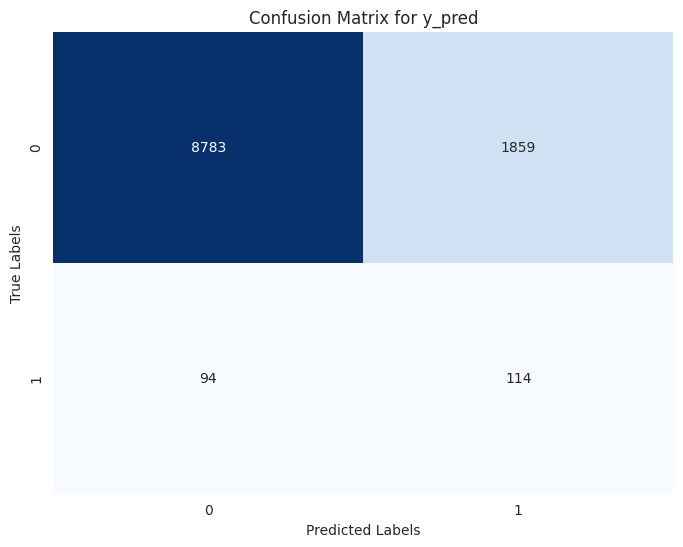

(0.82, 0.05778003041054232, 0.5480769230769231, 0.1045392022008253)

In [219]:
classifier = NaiveBayesClassifierFromScratch()
classifier.fit(np.array(X_train), np.array(Y_train))
y_pred = classifier.predict(np.array(X_test))
classifier.evaluate(Y_test, y_pred)

y_pred Metrics:
Accuracy: 0.7551152073732719
Precision: 0.050642201834862385
Recall: 0.6634615384615384
F1-score: 0.09410160245482442
Confusion Matrix:


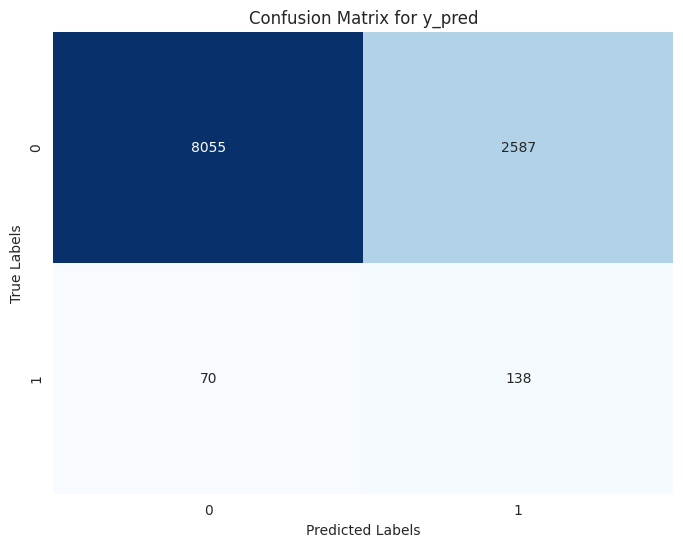

(0.7551152073732719,
 0.050642201834862385,
 0.6634615384615384,
 0.09410160245482442)

In [220]:
classifier = NaiveBayesClassifierFromScratch()
classifier.fit(np.array(X_smoteTrain), np.array(Y_smoteTrain))
y_pred_smote = classifier.predict(np.array(X_test))
classifier.evaluate(Y_test, y_pred_smote)

y_pred Metrics:
Accuracy: 0.7330875576036866
Precision: 0.05319148936170213
Recall: 0.7692307692307693
F1-score: 0.09950248756218906
Confusion Matrix:


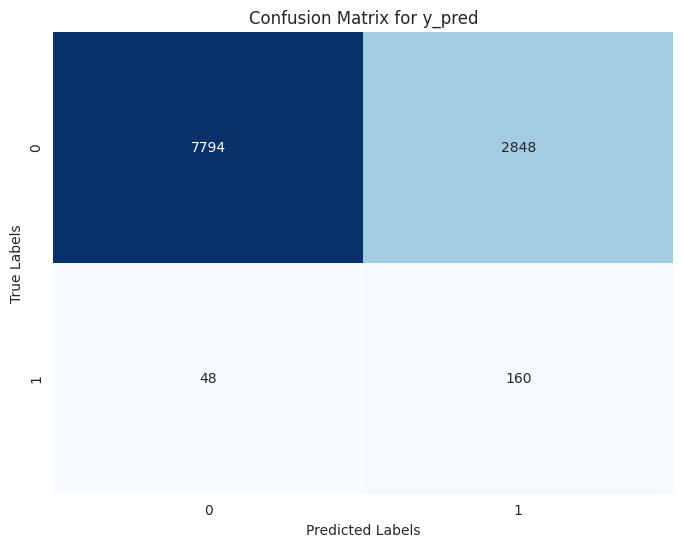

(0.7330875576036866,
 0.05319148936170213,
 0.7692307692307693,
 0.09950248756218906)

In [221]:
classifier = NaiveBayesClassifierFromScratch()
classifier.fit(np.array(X_randTrain), np.array(Y_randTrain))
y_pred_rand = classifier.predict(np.array(X_test))
classifier.evaluate(Y_test, y_pred_rand)

y_pred Metrics:
Accuracy: 0.82
Precision: 0.05778003041054232
Recall: 0.5480769230769231
F1-score: 0.1045392022008253
Confusion Matrix:


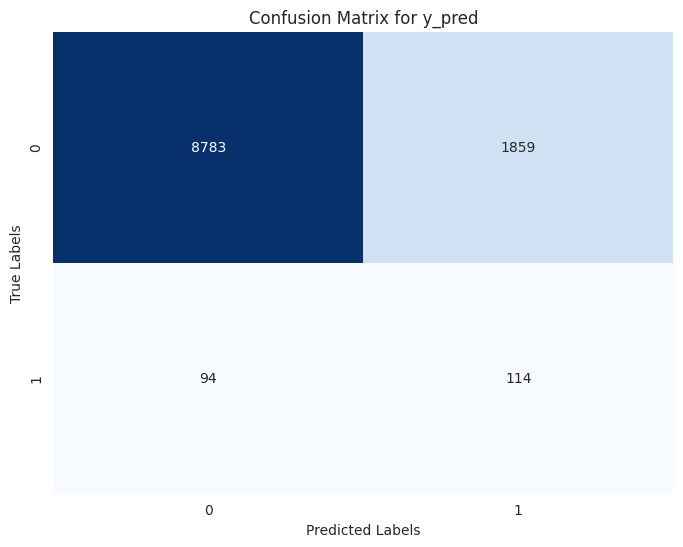

y_smote Metrics:
Accuracy: 0.7551152073732719
Precision: 0.050642201834862385
Recall: 0.6634615384615384
F1-score: 0.09410160245482442
Confusion Matrix:


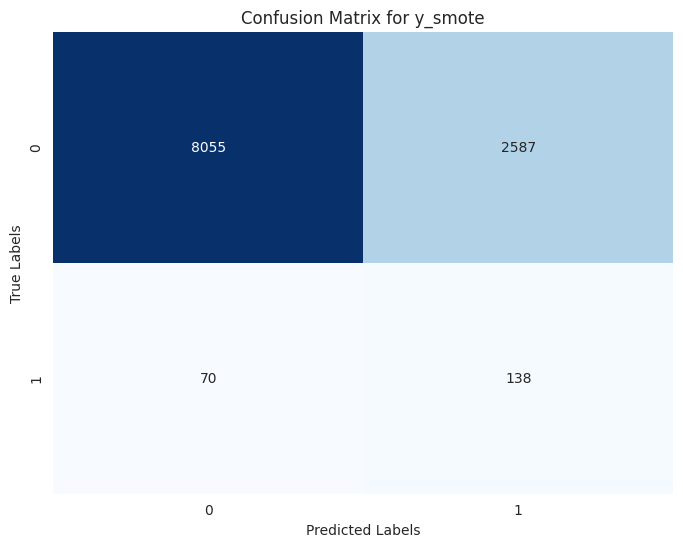

y_rand Metrics:
Accuracy: 0.7330875576036866
Precision: 0.05319148936170213
Recall: 0.7692307692307693
F1-score: 0.09950248756218906
Confusion Matrix:


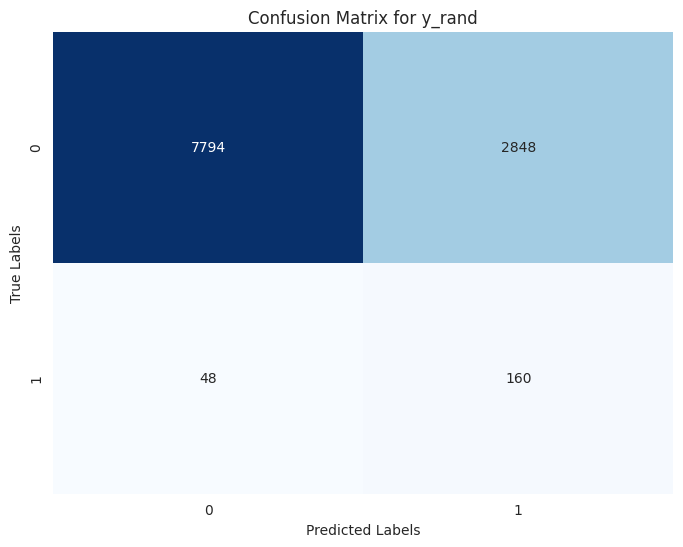

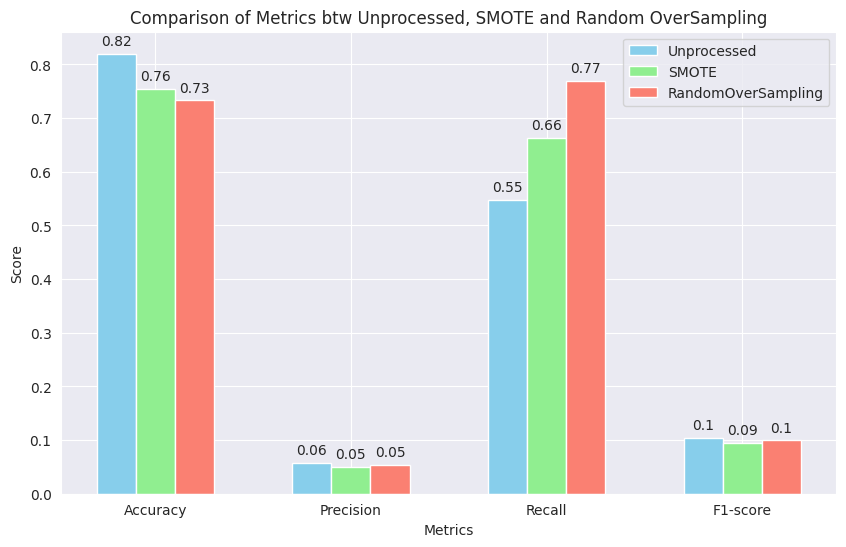

In [222]:
classifier.compare_performance(Y_test,y_pred,y_pred_smote,y_pred_rand)

y_pred Metrics:
Accuracy: 0.7551152073732719
Precision: 0.050642201834862385
Recall: 0.6634615384615384
F1-score: 0.09410160245482442
Confusion Matrix:


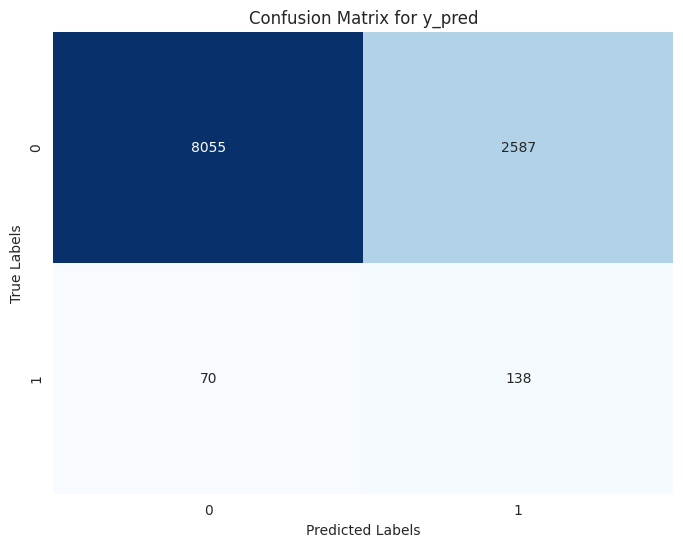

(0.7551152073732719,
 0.050642201834862385,
 0.6634615384615384,
 0.09410160245482442)

In [223]:
classifier = NaiveBayesClassifierFromScratch()
classifier.fit(np.array(X_resampledSMOTE_Train), np.array(y_resampledSMOTE_Train))
y_pred_smote_scratch = classifier.predict(np.array(X_test))
classifier.evaluate(Y_test, y_pred_smote)

y_pred Metrics:
Accuracy: 0.7551152073732719
Precision: 0.050642201834862385
Recall: 0.6634615384615384
F1-score: 0.09410160245482442
Confusion Matrix:


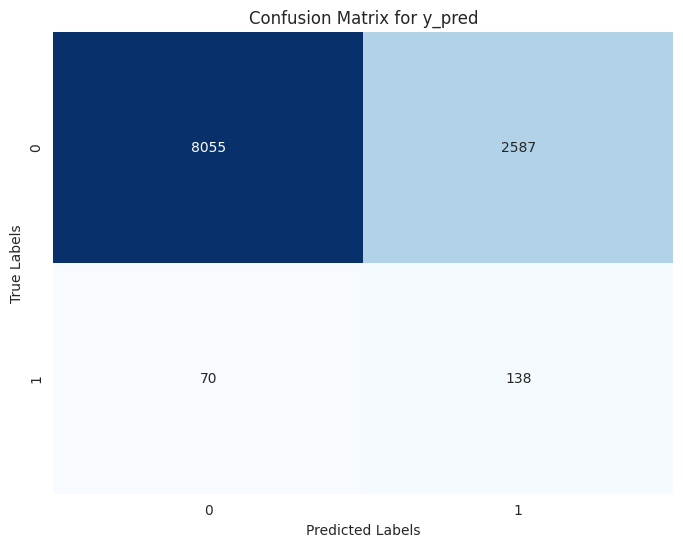

(0.7551152073732719,
 0.050642201834862385,
 0.6634615384615384,
 0.09410160245482442)

In [224]:
classifier = NaiveBayesClassifierFromScratch()
classifier.fit(np.array(X_resampledROS_Train), np.array(y_resampledROS_Train))
y_pred_ROS_scratch = classifier.predict(np.array(X_test))
classifier.evaluate(Y_test, y_pred_smote)

y_pred Metrics:
Accuracy: 0.82
Precision: 0.05778003041054232
Recall: 0.5480769230769231
F1-score: 0.1045392022008253
Confusion Matrix:


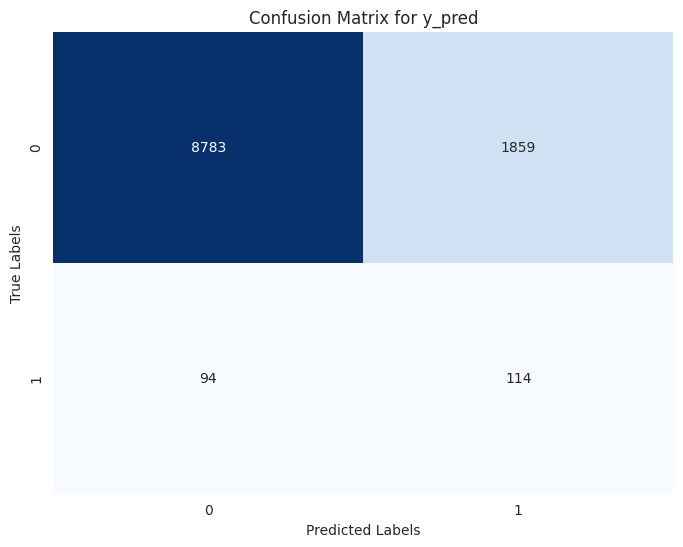

y_smote Metrics:
Accuracy: 0.6853456221198156
Precision: 0.04640633842671194
Recall: 0.7884615384615384
F1-score: 0.08765366114377338
Confusion Matrix:


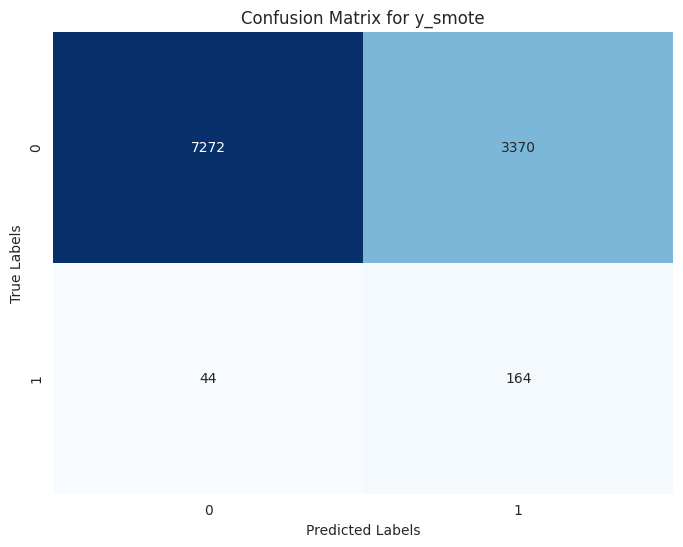

y_rand Metrics:
Accuracy: 0.7339170506912442
Precision: 0.053351117039013005
Recall: 0.7692307692307693
F1-score: 0.09978172747115685
Confusion Matrix:


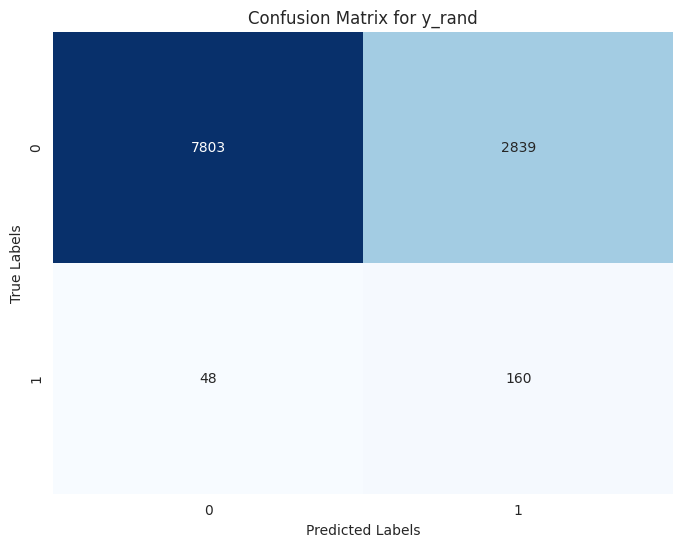

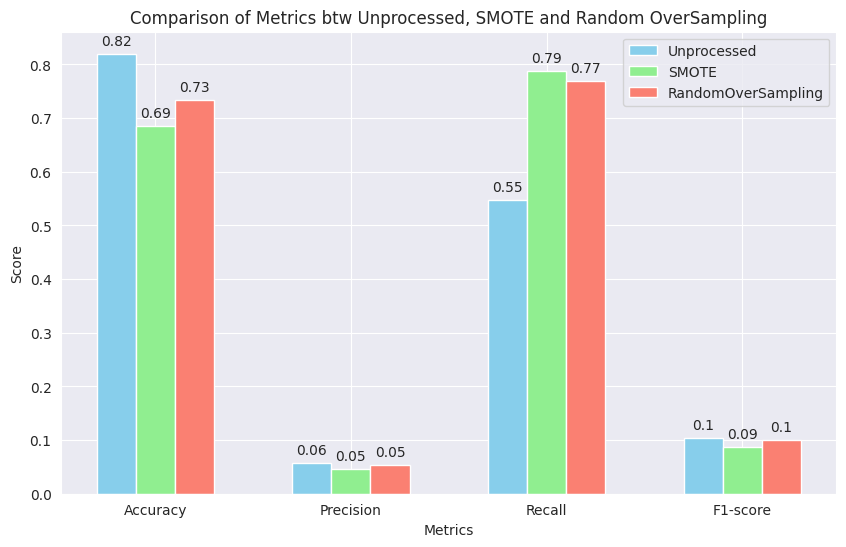

In [225]:
classifier.compare_performance(Y_test,y_pred,y_pred_smote_scratch,y_pred_ROS_scratch)

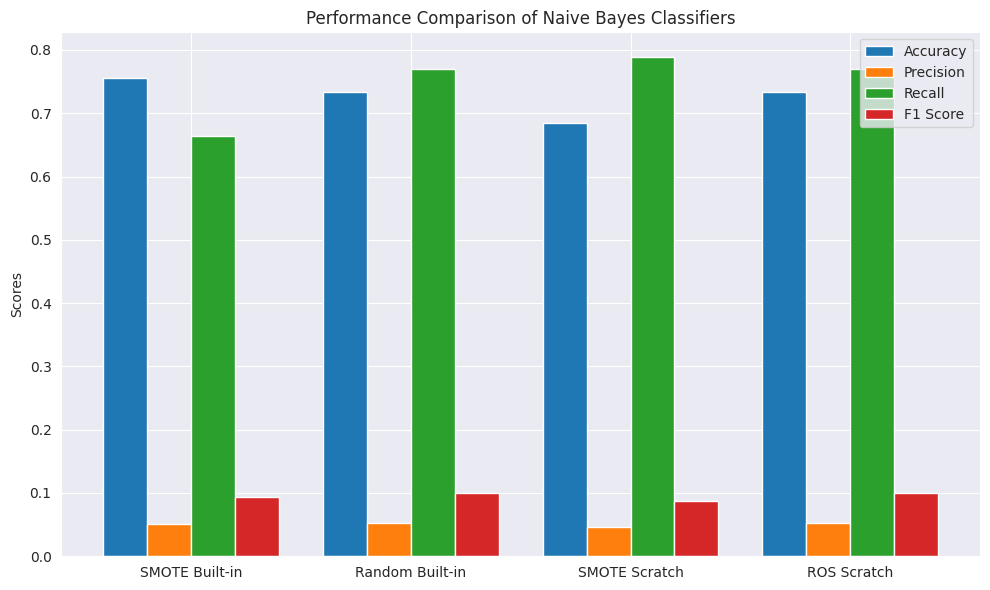

In [228]:
# Calculate performance metrics
accuracy_scores = [
    accuracy_score(Y_test, y_pred_smote),
    accuracy_score(Y_test, y_pred_rand),
    accuracy_score(Y_test, y_pred_smote_scratch),
    accuracy_score(Y_test, y_pred_ROS_scratch)
]

precision_scores = [
    precision_score(Y_test, y_pred_smote),
    precision_score(Y_test, y_pred_rand),
    precision_score(Y_test, y_pred_smote_scratch),
    precision_score(Y_test, y_pred_ROS_scratch)
]

recall_scores = [
    recall_score(Y_test, y_pred_smote),
    recall_score(Y_test, y_pred_rand),
    recall_score(Y_test, y_pred_smote_scratch),
    recall_score(Y_test, y_pred_ROS_scratch)
]

f1_scores = [
    f1_score(Y_test, y_pred_smote),
    f1_score(Y_test, y_pred_rand),
    f1_score(Y_test, y_pred_smote_scratch),
    f1_score(Y_test, y_pred_ROS_scratch)
]
# Plotting
labels = ['SMOTE Built-in', 'Random Built-in', 'SMOTE Scratch', 'ROS Scratch']
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 0.3, accuracy_scores, width=0.2, label='Accuracy')
ax.bar(x - 0.1, precision_scores, width=0.2, label='Precision')
ax.bar(x + 0.1, recall_scores, width=0.2, label='Recall')
ax.bar(x + 0.3, f1_scores, width=0.2, label='F1 Score')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Naive Bayes Classifiers')
ax.legend()

plt.tight_layout()
plt.show()


### Naive Bayes from sci-kit learn

In [213]:
class NaiveBayesClassifier:
    def __init__(self):
        self.nb_classifier = GaussianNB()
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_pred = None

    def train(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        # Compute sample weights based on class imbalance
        class_counts = np.bincount(y_train)
        class_weights = 1.0 / class_counts
        sample_weights = class_weights[y_train]
        self.nb_classifier.fit(self.X_train, self.y_train)
        #sample_weight=sample_weights

    def test(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = self.nb_classifier.predict(self.X_test)

    def print_evaluation_metrics(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        report = classification_report(self.y_test, self.y_pred)
        confusion = confusion_matrix(self.y_test, self.y_pred)
        print(f"Accuracy: {accuracy:.2f}")
        print("Classification Report:")
        print(report)
        print("Confusion Matrix:")
        # Plotting confusion matrix using Seaborn heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix')
        plt.show()


Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     10642
           1       0.08      0.36      0.13       208

    accuracy                           0.91     10850
   macro avg       0.53      0.64      0.54     10850
weighted avg       0.97      0.91      0.94     10850

Confusion Matrix:


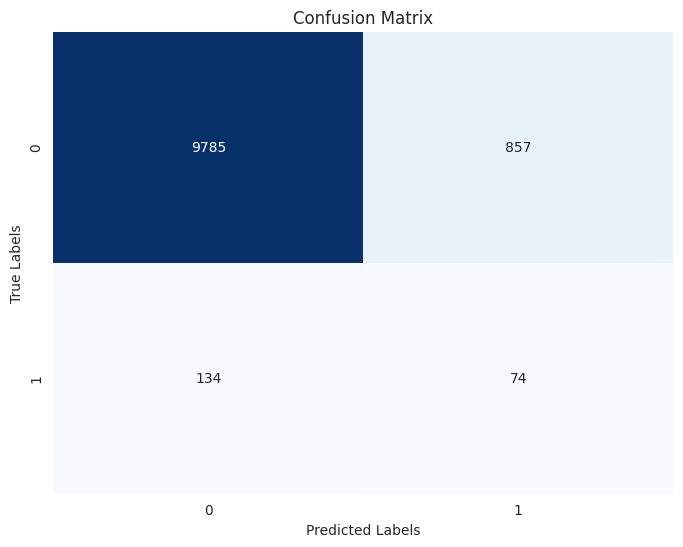

In [214]:
classifier = NaiveBayesClassifier()
classifier.train(X_train, Y_train)
classifier.test(X_test, Y_test)
classifier.print_evaluation_metrics()

Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     10642
           1       0.05      0.66      0.09       208

    accuracy                           0.76     10850
   macro avg       0.52      0.71      0.48     10850
weighted avg       0.97      0.76      0.84     10850

Confusion Matrix:


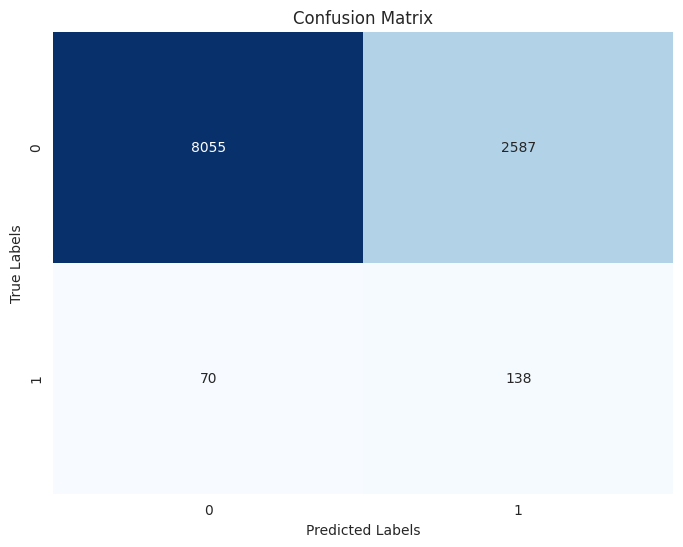

In [215]:
classifier = NaiveBayesClassifier()
classifier.train(X_smoteTrain, Y_smoteTrain)
classifier.test(X_test, Y_test)
classifier.print_evaluation_metrics()

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     10642
           1       0.05      0.77      0.10       208

    accuracy                           0.73     10850
   macro avg       0.52      0.75      0.47     10850
weighted avg       0.98      0.73      0.83     10850

Confusion Matrix:


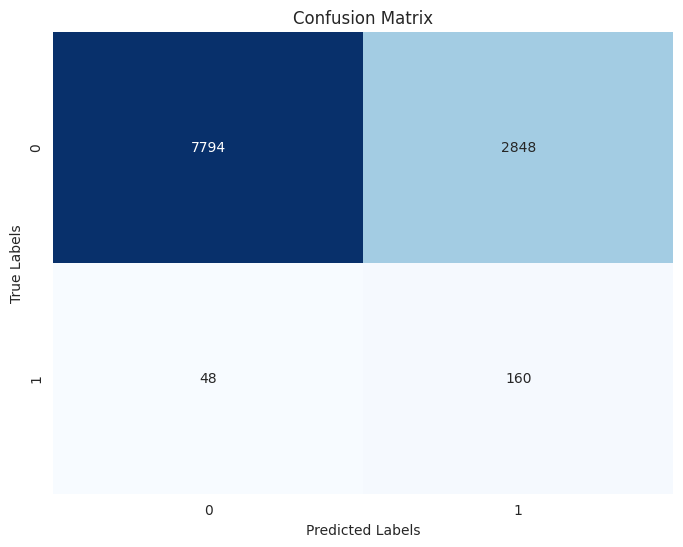

In [216]:
classifier = NaiveBayesClassifier()
classifier.train(X_randTrain, Y_randTrain)
classifier.test(X_test, Y_test)
classifier.print_evaluation_metrics()

##  13. Decision Tree Implementation
#### We will implement decision tree from scratch and evaluate performance

In [132]:
class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None

    def node_def(self) -> str:

        if (self.left or self.right):
            return f"NODE | Information Gain = {self.information_gain} | Split IF X[{self.feature_idx}] < {self.feature_val} THEN left O/W right"
        else:
            unique_values, value_counts = np.unique(self.data[:,-1], return_counts=True)
            output = ", ".join([f"{value}->{count}" for value, count in zip(unique_values, value_counts)])
            return f"LEAF | Label Counts = {output} | Pred Probs = {self.prediction_probs}"

In [206]:
class DecisionTree():
    """
    Decision Tree Classifier
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    """

    def __init__(self, max_depth=4, min_samples_leaf=1,
                 min_information_gain=0.0, numb_of_features_splitting=None,
                 amount_of_say=None) -> None:
        """
        Setting the class with hyperparameters
        max_depth: (int) -> max depth of the tree
        min_samples_leaf: (int) -> min # of samples required to be in a leaf to make the splitting possible
        min_information_gain: (float) -> min information gain required to make the splitting possible
        num_of_features_splitting: (str) ->  when splitting if sqrt then sqrt(# of features) features considered,
                                                            if log then log(# of features) features considered
                                                            else all features are considered
        amount_of_say: (float) -> used for Adaboost algorithm
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.amount_of_say = amount_of_say

    def _entropy(self, class_probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p>0])

    def _class_probabilities(self, labels: list) -> list:
        total_count = len(labels)
        return [label_count / total_count for label_count in Counter(labels).values()]

    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))

    def _partition_entropy(self, subsets: list) -> float:
        """subsets = list of label lists (EX: [[1,0,0], [1,1,1])"""
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])

    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:

        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]

        return group1, group2

    def _select_features_to_use(self, data: np.array) -> list:
        """
        Randomly selects the features to use while splitting w.r.t. hyperparameter numb_of_features_splitting
        """
        feature_idx = list(range(data.shape[1]-1))

        if self.numb_of_features_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.sqrt(len(feature_idx))))
        elif self.numb_of_features_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.log2(len(feature_idx))))
        else:
            feature_idx_to_use = feature_idx

        return feature_idx_to_use

    def _find_best_split(self, data: np.array) -> tuple:
        """
        Finds the best split (with the lowest entropy) given data
        Returns 2 splitted groups and split information
        """
        min_part_entropy = 1e9
        feature_idx_to_use =  self._select_features_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                g1, g2, = self._split(data, idx, feature_val)
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy

    def _find_label_probs(self, data: np.array) -> np.array:

        labels_as_integers = data[:,-1].astype(int)
        # Calculate the total number of labels
        total_labels = len(labels_as_integers)
        # Calculate the ratios (probabilities) for each label
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)

        # Populate the label_probabilities array based on the specific labels
        for i, label in enumerate(self.labels_in_train):
            label_index = np.where(labels_as_integers == i)[0]
            if len(label_index) > 0:
                label_probabilities[i] = len(label_index) / total_labels

        return label_probabilities

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        """
        Recursive, depth first tree creation algorithm
        """

        # Check if the max depth has been reached (stopping criteria)
        if current_depth > self.max_depth:
            return None

        # Find best split
        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)

        # Find label probs for the node
        label_probabilities = self._find_label_probs(data)

        # Calculate information gain
        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy

        # Create node
        node = TreeNode(data, split_feature_idx, split_feature_val, label_probabilities, information_gain)

        # Check if the min_samples_leaf has been satisfied (stopping criteria)
        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        # Check if the min_information_gain has been satisfied (stopping criteria)
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)

        return node

    def _predict_one_sample(self, X: np.array) -> np.array:
        """Returns prediction for 1 dim array"""
        node = self.tree

        # Finds the leaf which X belongs
        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """
        Trains the model with given X and Y datasets
        """

        # Concat features and labels
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        # Start creating the tree
        self.tree = self._create_tree(data=train_data, current_depth=0)

        # Calculate feature importance
        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        # Normalize the feature importance values
        self.feature_importances = {k: v / total for total in (sum(self.feature_importances.values()),) for k, v in self.feature_importances.items()}

    def predict_proba(self, X_set: np.array) -> np.array:
        """Returns the predicted probs for a given data set"""

        pred_probs = np.apply_along_axis(self._predict_one_sample, 1, X_set)

        return pred_probs

    def predict(self, X_set: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)

        return preds

    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node != None:
            self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_def())
            self._print_recursive(node.right, level + 1)

    def print_tree(self) -> None:
        self._print_recursive(node=self.tree)

    def _calculate_feature_importance(self, node):
        """Calculates the feature importance by visiting each node in the tree recursively"""
        if node != None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)

##### We will let max depth = 6 and minimum number of leaves in a node = 1

In [207]:
tree_regularDataset = DecisionTree(max_depth=4,min_samples_leaf=1)
tree_smoteDataset = DecisionTree(max_depth=4,min_samples_leaf=1)
tree_randDataset = DecisionTree(max_depth=4,min_samples_leaf=1)

In [208]:
tree_regularDataset.train(X_train,Y_train)

tree_smoteDataset.train(X_smoteTrain,Y_smoteTrain)

tree_randDataset.train(X_randTrain,Y_randTrain)

#### We will now evaluate performance
##### First checking on the regular (biased) dataset

In [209]:
test_pred = tree_regularDataset.predict(X_set=X_test)
print("Test size:", len(Y_test))
print("True predictions:", sum(test_pred == Y_test))
print("Accuracy:", sum(test_pred == Y_test) / len(Y_test))
print("Precision:", precision_score(Y_test, test_pred))
print("Recall:", recall_score(Y_test, test_pred))
print("F1-score:", f1_score(Y_test, test_pred))

Test size: 10850
True predictions: 10642
Accuracy: 0.9808294930875576
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### This was expected since our original training dataset (as well as the testing dataset) are biased towards class 0

#### Now, evaluating it for decision tree trained on SMOTE processed dataset

In [211]:
test_pred = tree_smoteDataset.predict(X_set=X_test)
print("Test size:", len(Y_test))
print("True predictions:", sum(test_pred == Y_test))
print("Accuracy:", sum(test_pred == Y_test) / len(Y_test))
print("Precision:", precision_score(Y_test, test_pred))
print("Recall:", recall_score(Y_test, test_pred))
print("F1-score:", f1_score(Y_test, test_pred))


Test size: 10850
True predictions: 7647
Accuracy: 0.7047926267281106
Precision: 0.0485378353934278
Recall: 0.7740384615384616
F1-score: 0.09134751773049644


#### For, decision trained on dataset processed via random oversampling

In [212]:
test_pred = tree_randDataset.predict(X_set=X_test)
print("Test size:", len(Y_test))
print("True predictions:", sum(test_pred == Y_test))
print("Accuracy:", sum(test_pred == Y_test) / len(Y_test))
print("Precision:", precision_score(Y_test, test_pred))
print("Recall:", recall_score(Y_test, test_pred))
print("F1-score:", f1_score(Y_test, test_pred))


Test size: 10850
True predictions: 8463
Accuracy: 0.78
Precision: 0.05729378301503454
Recall: 0.6778846153846154
F1-score: 0.10565754964406146


In [ ]:
# Data
labels = ['SMOTE', 'Randomly Oversampled', 'Unprocessed']
accuracy = [0.7047926267281106, 0.78, 0.9808294930875576]
precision = [0.5211493106344545, 0.52465356691579, 0.4904147465437788]
recall = [0.7387388323478814, 0.7299402404117213, 0.5]
f1_score = [0.45755821553649995, 0.4901153073216367, 0.4851609901358645]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision', color='lightgreen')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall', color='salmon')
rects4 = ax.bar(x + 1.5*width, f1_score, width, label='F1-score', color='lightpink')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Evaluation of Decision Tree on Different Datasets', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=10)
#ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=0)  # Rotate x labels for better readability

# Adding labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
plt.savefig("help.png")
plt.show()


As oversampling while overcoming unbalanced dataset issues gave better accuracy compared to SMOTE we will be doing further evaluation on it only

## 1. Variation of performance wrt depth of tree

In [142]:
precisions = []
recalls = []
f1_scores = []

for i in range(1, 50):
    tree_randDataset = DecisionTree(max_depth=i, min_samples_leaf=1)
    tree_randDataset.train(X_smoteTrain, Y_smoteTrain)
    test_pred = tree_randDataset.predict(X_set=X_test)

    precision = precision_score(Y_test, test_pred, average='macro')
    recall = recall_score(Y_test, test_pred, average='macro')
    f1 = f1_score(Y_test, test_pred, average='macro')

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)


KeyboardInterrupt



In [ ]:

# Define the degree of the polynomial
degree = len(precisions) - 1

# Fit polynomial curve to precision data
coefficients_precision = np.polyfit(range(1, 50), precisions, degree)
poly_precision = np.poly1d(coefficients_precision)

# Fit polynomial curve to recall data
coefficients_recall = np.polyfit(range(1, 50), recalls, degree)
poly_recall = np.poly1d(coefficients_recall)

# Fit polynomial curve to F1 score data
coefficients_f1 = np.polyfit(range(1, 50), f1_scores, degree)
poly_f1 = np.poly1d(coefficients_f1)



plt.figure(figsize=(10, 5))
#plt.plot(range(1, 50), f1_scores, marker='', color='green', label='F1 Score')
plt.plot(range(1, 50), poly_recall(range(1, 50)), color='orange', label=' Recall')
plt.plot(range(1, 50), poly_precision(range(1, 50)), color='blue', label='Precision')
plt.plot(range(1, 50), poly_f1(range(1, 50)), color='red', label=' F1 Score')


plt.title('Variation of Precision, Recall and F1 Score with depth of Tree')
plt.xlabel('Depth of Tree')
plt.ylabel('Score')
plt.grid(False)
plt.yticks(np.arange(0.3, 1, 0.1))
plt.legend()
plt.savefig("decisiontree_depth.png")
plt.show()

# Results visualization for Decision Tree

As we got highest F1 score of 0.78 for decision tree of maximum depth 20, we visualize the results for the same by plotting a confusion matrix

In [ ]:
precisions=[]
recalls=[]
f1_scores=[]
for i in range(1, 50):
    tree_randDataset = DecisionTree(max_depth=20, min_samples_leaf=i)
    tree_randDataset.train(X_smoteTrain, Y_smoteTrain)
    test_pred = tree_randDataset.predict(X_set=X_test)

    precision = precision_score(Y_test, test_pred, average='macro')
    recall = recall_score(Y_test, test_pred, average='macro')
    f1 = f1_score(Y_test, test_pred, average='macro')

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

In [ ]:
np.argmax(precisions)

In [191]:
class HardVotingClassifier:
    def __init__(self, classifiers):
        self.classifiers = classifiers
    
    def fit(self, X_train, y_train):
        self.classifiers[0].fit(X_train, y_train)
        self.classifiers[1].fit(X_train, y_train)
        self.classifiers[2].train(X_train, y_train)

    
    def predict(self, X_test):
        # Get predictions from each classifier
        predictions = [clf.predict(X_test) for clf in self.classifiers]
        # Transpose to align predictions by samples
        predictions = np.array(predictions).T
        # Use majority voting to determine final prediction
        y_pred = [np.argmax(np.bincount(pred)) for pred in predictions]
        return y_pred

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        print("Accuracy:", accuracy)
        print("F1 Score:", f1)
        print("Precision:", precision)
        print("Recall:", recall)
        print("Confusion Matrix:")
        # Plotting confusion matrix using Seaborn heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix')
        plt.show()

    def evaluate1(self, y_true, y_pred, label='y_pred'):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        confusion = confusion_matrix(y_true, y_pred)
        print(f"{label} Metrics:")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-score:", f1)
        print("Confusion Matrix:")

        # Plotting confusion matrix using Seaborn heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {label}')
        plt.show()

        return accuracy, precision, recall, f1
    
    def compare_performance(self, y_true, y_pred, y_smote, y_rand):
        # Evaluate metrics for each set of predictions
        metrics_y_pred = self.evaluate1(y_true, y_pred, label='y_pred')
        metrics_y_smote = self.evaluate1(y_true, y_smote, label='y_smote')
        metrics_y_rand = self.evaluate1(y_true, y_rand, label='y_rand')

        # Plot comparison between metrics
        labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
        metrics_names = ['accuracy', 'precision', 'recall', 'f1']
        y_pred_metrics = [metrics_y_pred[0], metrics_y_pred[1], metrics_y_pred[2], metrics_y_pred[3]]
        y_smote_metrics = [metrics_y_smote[0], metrics_y_smote[1], metrics_y_smote[2], metrics_y_smote[3]]
        y_rand_metrics = [metrics_y_rand[0], metrics_y_rand[1], metrics_y_rand[2], metrics_y_rand[3]]

        x = range(len(labels))
        width = 0.2  # Bar width

        plt.figure(figsize=(10, 6))

        bars1 = plt.bar(x, y_pred_metrics, width=width, label='Unprocessed', align='center',color='skyblue')
        bars2 = plt.bar([p + width for p in x], y_smote_metrics, width=width, label='SMOTE', align='center', color='lightgreen')
        bars3 = plt.bar([p + width * 2 for p in x], y_rand_metrics, width=width, label='RandomOverSampling', align='center', color='salmon')

        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.title('Comparison of Metrics btw Unprocessed, SMOTE and Random OverSampling')
        plt.xticks([p + width for p in x], labels)
        plt.legend()


        # Add exact metric values on the bars
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

        plt.show()


Accuracy: 0.82
F1 Score: 0.8846953382916922
Precision: 0.9715510021770185
Recall: 0.82
Confusion Matrix:


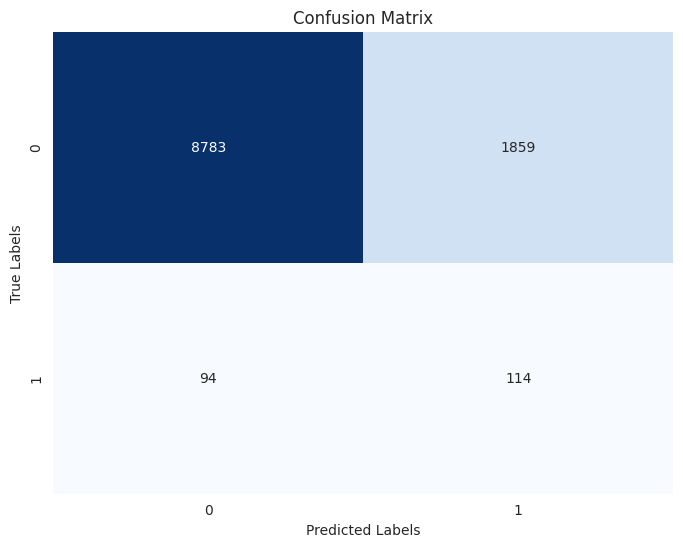

In [192]:
classifiers = [
    NaiveBayesClassifierFromScratch(),
    LogisticRegressionFromScratch(threshold=0.0076, num_iterations=140),
    DecisionTree(max_depth=4,min_samples_leaf=1)
]
voting_classifier = HardVotingClassifier(classifiers)
voting_classifier.fit(X_train, Y_train)
y_pred = voting_classifier.predict(X_test)
voting_classifier.evaluate(X_test, Y_test)

Accuracy: 0.6752073732718894
F1 Score: 0.7886879695780581
Precision: 0.9769592641586444
Recall: 0.6752073732718894
Confusion Matrix:


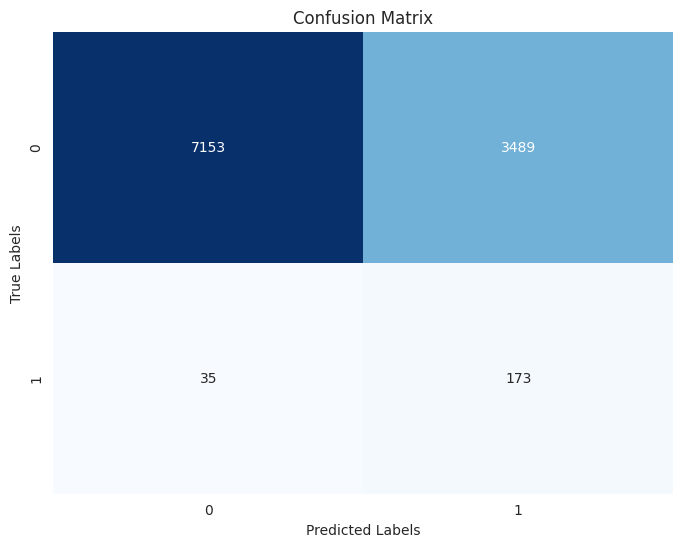

In [193]:
classifiers = [
    NaiveBayesClassifierFromScratch(),
    LogisticRegressionFromScratch(threshold=0.009, num_iterations=140),
    DecisionTree(max_depth=4,min_samples_leaf=1)
]
voting_classifier = HardVotingClassifier(classifiers)
voting_classifier.fit(np.array(X_resampledSMOTE_Train), np.array(y_resampledSMOTE_Train))
y_pred_smote = voting_classifier.predict(np.array(X_test))
voting_classifier.evaluate(np.array(X_test), np.array(Y_test))

Accuracy: 0.6964976958525345
F1 Score: 0.8038209779123953
Precision: 0.9771689423997468
Recall: 0.6964976958525345
Confusion Matrix:


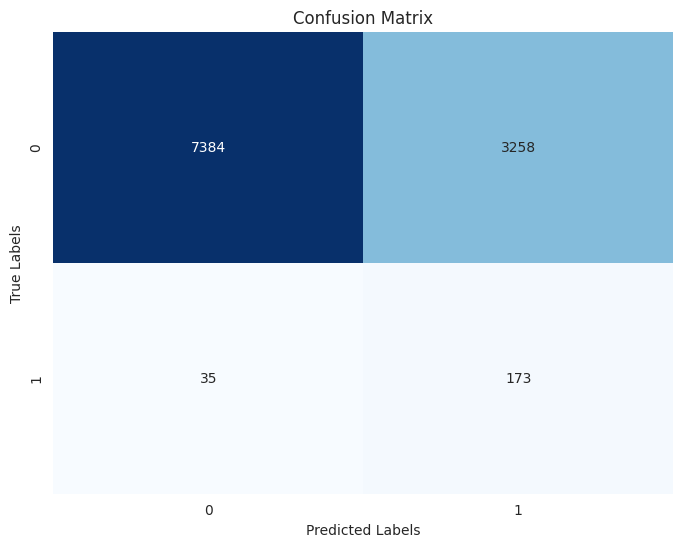

In [194]:
classifiers = [
    NaiveBayesClassifierFromScratch(),
    LogisticRegressionFromScratch(threshold=0.05, num_iterations=140),
    DecisionTree(max_depth=4,min_samples_leaf=1)
]
voting_classifier = HardVotingClassifier(classifiers)
voting_classifier.fit(np.array(X_resampledROS_Train), np.array(y_resampledROS_Train))
y_pred_rand = voting_classifier.predict(np.array(X_test))
voting_classifier.evaluate(np.array(X_test), np.array(Y_test))

y_pred Metrics:
Accuracy: 0.82
Precision: 0.05778003041054232
Recall: 0.5480769230769231
F1-score: 0.1045392022008253
Confusion Matrix:


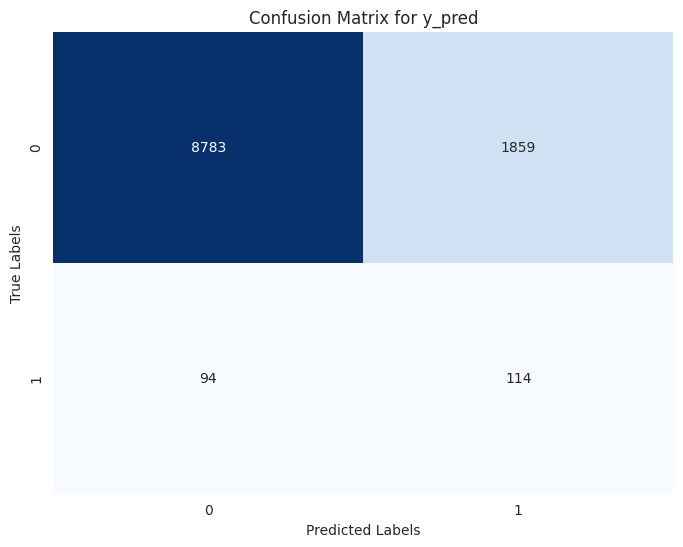

y_smote Metrics:
Accuracy: 0.6752073732718894
Precision: 0.04724194429273621
Recall: 0.8317307692307693
F1-score: 0.08940568475452197
Confusion Matrix:


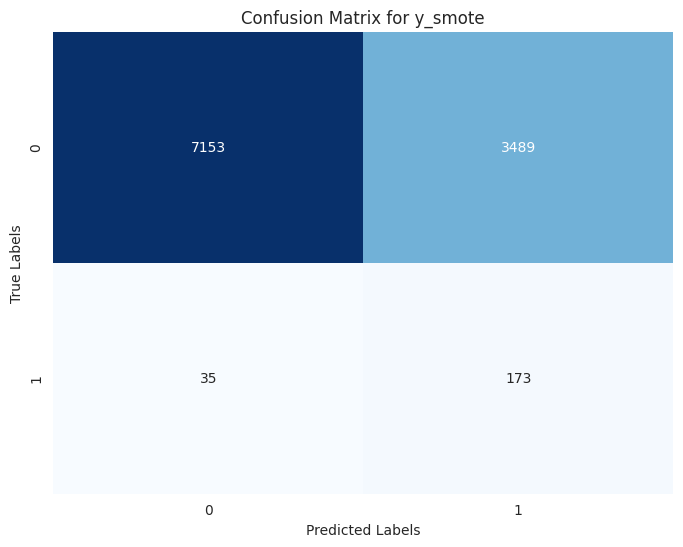

y_rand Metrics:
Accuracy: 0.6964976958525345
Precision: 0.05042261731273681
Recall: 0.8317307692307693
F1-score: 0.09508106622698545
Confusion Matrix:


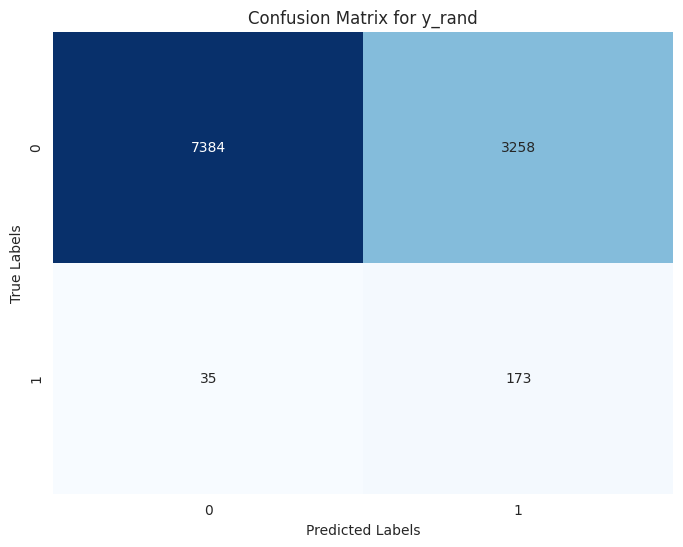

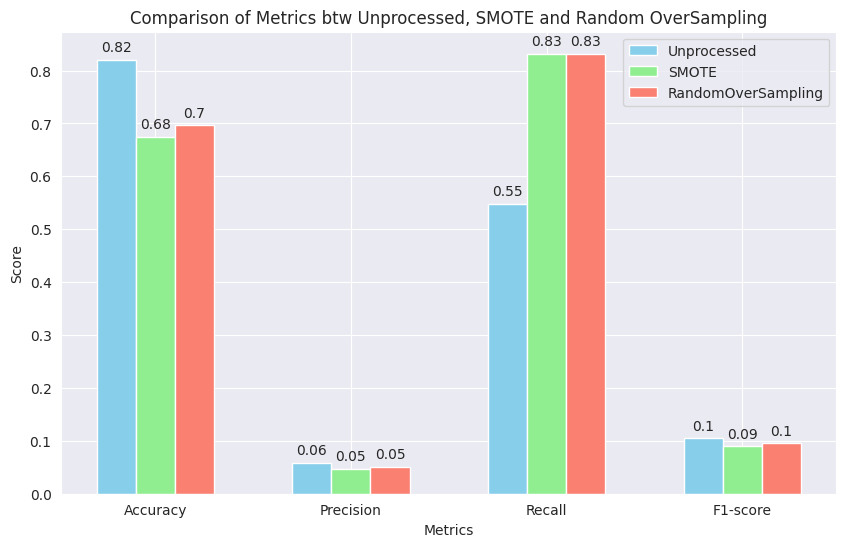

In [195]:
voting_classifier.compare_performance(Y_test,y_pred,y_pred_smote,y_pred_rand)